# Moscow Marathon Full Results 2018


## 1_full_results_mm_2018.csv

Columns : {Bib, finish_time_sec, finish_time_result, race, pace_sec, pace(minpkm), pace(kmph), half_pace_sec, half_pace(minpkm), half_pace(kmph), gender_en, agev name_en, location_city_ru, location_city_en, country_code_alpha_3, flag_DNF, flag_all_split_exist, race_uniform_index}

Data : {1, 8911, 2h 28min 31sec, 42.195 km, 211.1861595, 3:31 min/km 17.0 km/h, 208.3185212, 3:28 min/km, 17.3 km/h, Female, 30, Sardana Trofimova, –Ø–∫—É—Ç—Å–∫, Yakutsk, RUS, 0, 1, 0.000132899}

## 1_split_results_mm_2018.csv

Columns : {bib, split_name, split, split_time_sec, split_time_result, split_pace_sec, split_pace(minpkm), split_pace(kmph), split_uniform_index}

Data : {11, Kirui, Geoffrey, 24, M, Keringet, KEN, 0:15:25, 0:30:28, 0:45:44, 1:01:15, 1:04:35, 1:16:59, 1:33:01, 1:48:19, 2:02:53, 0:04:57, - 2:09:37, 1, 1, 11}

In [28]:
from datetime import datetime
import numpy as np
import pandas as pd

# 데이터 불러오기
full_df = pd.read_csv('./data/1_full_results_mm_2018.csv')
split_df = pd.read_csv('./data/1_split_results_mm_2018.csv')

# bib 통일
full_df['bib'] = full_df['bib'].astype(str)
split_df['bib'] = split_df['bib'].astype(str)

# --------------------------
# split_time_sec pivot (5K~40K만)
split_time = split_df.pivot_table(index='bib', columns='split_name', values='split_time_sec')

# Marathon 열 제거
split_time = split_time.drop(columns=['Half marathon','Marathon'], errors='ignore')

# ' km' 제거 후 'K' 붙이기
split_time.columns = [col.replace(' km', '') + 'K' for col in split_time.columns]
split_time = split_time.apply(pd.to_numeric, errors='coerce')
split_time.reset_index(inplace=True)

# --------------------------
# split_pace_sec pivot (5p~40p만)
split_pace = split_df.pivot_table(index='bib', columns='split_name', values='split_pace_sec')
split_pace = split_pace.drop(columns=['Half marathon', 'Marathon'], errors='ignore')

split_pace.columns = [col.replace(' km', '') + 'p' for col in split_pace.columns]
split_pace = split_pace.apply(pd.to_numeric, errors='coerce')
split_pace.reset_index(inplace=True)

#--------------------------------------
# Half marathon 기록 추출
half_time = split_df[split_df['split_name'] == 'Half marathon'][['bib', 'split_time_sec']].copy()
half_time.rename(columns={'split_time_sec': 'Half'}, inplace=True)

half_pace = split_df[split_df['split_name'] == 'Half marathon'][['bib', 'split_pace_sec']].copy()
half_pace.rename(columns={'split_pace_sec': 'Halfp'}, inplace=True)

# 병합
split_time = split_time.merge(half_time, how='left', on='bib')
split_pace = split_pace.merge(half_pace, how='left', on='bib')



# --------------------------
# 필요한 컬럼 선택 및 전처리
reduced_df = full_df[['bib', 'age', 'gender_en', 'country_code_alpha_3', 'finish_time_sec']].copy()
reduced_df.rename(columns={
    'bib': 'Bib',
    'age': 'Age',
    'gender_en': 'M/F',
    'country_code_alpha_3': 'Country',
    'finish_time_sec': 'Final_Time'
}, inplace=True)

# Final_Time이 NaN인 경우 제거
reduced_df = reduced_df.dropna(subset=['Final_Time'])

# Age_group (19이하 → 19, ..., 70 이상 → 70)
def age_group(age):
    if age <= 19:
        return 19
    elif age >= 70:
        return 70
    else:
        return (age // 5) * 5 + 4  # 20~24 → 24, 25~29 → 29, ...

reduced_df['Age_group'] = reduced_df['Age'].apply(age_group)

# M/F: Male → 0, Female → 1
reduced_df['M/F'] = reduced_df['M/F'].map({'Male': 0, 'Female': 1})

# Sub 그룹핑
def set_sub_group(seconds):
    if pd.isna(seconds):
        return pd.NA
    hours = seconds / 3600
    if hours < 3:
        return 3
    elif hours < 4:
        return 4
    elif hours < 5:
        return 5
    elif hours < 6:
        return 6
    else:
        return 7

reduced_df['Sub'] = reduced_df['Final_Time'].apply(set_sub_group).astype('Int64')

# --------------------------
# 병합
merged = reduced_df.merge(split_time, how='left', left_on='Bib', right_on='bib')
merged = merged.merge(split_pace, how='left', on='bib')
merged.drop(columns=['bib'], inplace=True)

# Dataset 컬럼 추가
merged['Dataset'] = 'M'

merged['Year'] = 2018

merged.info()




# --------------------------
# 컬럼 순서 지정 (5~40K, 5~40p만 포함)
pace_cols = [f'{k}p' for k in range(5, 45, 5)]
time_cols = [f'{k}K' for k in range(5, 45, 5)]

columns_order = ['Bib', 'Age_group', 'M/F', 'Country'] + \
                pace_cols + ['Final_Time', 'Sub'] + \
                time_cols + ['Dataset'] + \
                ['Year', 'Half', 'Halfp']

# 존재하는 컬럼만 유지
columns_order = [col for col in columns_order if col in merged.columns]

# 결측치 제거
Moscow_df = merged[columns_order].dropna()

# Bib 재설정
Moscow_df['Bib'] = range(1, len(Moscow_df) + 1)
cols = Moscow_df.columns.tolist()
cols.remove('Bib')
Moscow_df = Moscow_df[['Bib'] + cols]

# int 변환
int_cols = Moscow_df.columns.difference(['Country', 'Dataset'])
Moscow_df[int_cols] = Moscow_df[int_cols].astype(int)

Moscow_df = Moscow_df[["Bib", "Age_group", "M/F", "Country", "5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p", "Final_Time", "Sub", "5K", "10K", "15K", "Half", "25K", "30K", "35K", "40K", "Dataset", "Year"]]


# 저장
Moscow_df.to_csv('./data/Moscow_Marathon_Processed.csv', index=False)

# 확인
print(Moscow_df.head())
# Moscow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21385 entries, 0 to 21384
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bib         21385 non-null  object 
 1   Age         21385 non-null  int64  
 2   M/F         21385 non-null  int64  
 3   Country     21385 non-null  object 
 4   Final_Time  21385 non-null  float64
 5   Age_group   21385 non-null  int64  
 6   Sub         21385 non-null  Int64  
 7   10K         21384 non-null  float64
 8   15K         8692 non-null   float64
 9   25K         8692 non-null   float64
 10  30K         8670 non-null   float64
 11  35K         8659 non-null   float64
 12  40K         8656 non-null   float64
 13  5K          21361 non-null  float64
 14  Half        8702 non-null   float64
 15  10p         21384 non-null  float64
 16  15p         8692 non-null   float64
 17  25p         8692 non-null   float64
 18  30p         8670 non-null   float64
 19  35p         8659 non-null

# Finishers Boston Marathon 2015, 2016 & 2017

In [29]:
import pandas as pd
import numpy as np

# CSV 파일 로드
df_15 = pd.read_csv('./data/marathon_results_2015.csv')
df_16 = pd.read_csv('./data/marathon_results_2016.csv')
df_17 = pd.read_csv('./data/marathon_results_2017.csv')

# 연도 컬럼 추가
df_15['Year'] = 2015
df_16['Year'] = 2016
df_17['Year'] = 2017

# 데이터 통합
df = pd.concat([df_15, df_16, df_17], ignore_index=True)

df = df.rename(columns={"Half": "HalfK"})


# 불필요한 컬럼 제거
drop_cols = ['Unnamed: 0', 'Unnamed: 8', 'Unnamed: 9', 'State', 'Citizen', 'Proj Time']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# 시간형 컬럼 처리 대상: 21K는 제거 대상
time_cols = ['5K', '10K', '15K', 'HalfK', '25K', '30K', '35K', '40K', 'Pace', 'Official Time']
for col in time_cols:
    df[col] = pd.to_timedelta(df[col], errors='coerce')

# 초 단위로 변환
for col in ['5K', '10K', '15K', 'HalfK', '25K', '30K', '35K', '40K', 'Official Time']:
    df[col] = df[col].dt.total_seconds()

# 컬럼명 변경
df.rename(columns={'Official Time': 'Final_Time'}, inplace=True)

# 페이스 계산 (21K 제외)
distance_km = {'5K': 5, '10K': 10, '15K': 15, 'HalfK': 21.0975, '25K': 25, '30K': 30, '35K': 35, '40K': 40}
for dist, km in distance_km.items():
    pace_col = dist.replace('K', 'p')
    df[pace_col] = df[dist] / km

# Age_group 지정
def age_group(age):
    if age < 20:
        return 19
    elif age < 25:
        return 24
    elif age < 30:
        return 29
    elif age < 35:
        return 34
    elif age < 40:
        return 39
    elif age < 45:
        return 44
    elif age < 50:
        return 49
    elif age < 55:
        return 54
    elif age < 60:
        return 59
    elif age < 65:
        return 64
    elif age < 70:
        return 69
    else:
        return 70

df['Age_group'] = df['Age'].apply(age_group)

# 성별 인코딩
df['M/F'] = df['M/F'].map({'M': 0, 'F': 1})

# Sub (시간 그룹)
def sub_group(time_sec):
    hours = time_sec / 3600
    if hours <= 3:
        return 3
    elif hours <= 4:
        return 4
    elif hours <= 5:
        return 5
    elif hours <= 6:
        return 6
    else:
        return 7

df['Sub'] = df['Final_Time'].apply(sub_group)

# 필요한 컬럼만 추출
base_cols = ['Bib', 'Age_group', 'M/F', 'Country']
pace_cols = [k.replace('K', 'p') for k in distance_km.keys()]
time_cols = list(distance_km.keys())
final_cols = ['Final_Time', 'Sub']
df['Dataset'] = 'B'

ordered_cols = base_cols + pace_cols + final_cols + time_cols + ['Dataset', 'Year']
df = df[ordered_cols]

# 결측치 제거 및 Bib 재할당
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df['Bib'] = df.index + 1

# 숫자형 컬럼 int로 변환
int_cols = df.columns.difference(['Country', 'Dataset'])
df[int_cols] = df[int_cols].astype(int)

df = df.rename(columns={"HalfK": "Half"})


# 저장
df.to_csv('./data/boston_processed.csv', index=False)

# 결과 확인
print(df.head())
# df.info()

   Bib  Age_group  M/F Country   5p  10p  15p  Halfp  25p  30p  ...   5K  \
0    1         29    0     ETH  176  178  179    182  182  184  ...  883   
1    2         34    0     ETH  176  178  179    182  182  183  ...  883   
2    3         29    0     KEN  176  178  179    182  182  184  ...  883   
3    4         29    0     KEN  176  178  180    182  182  184  ...  883   
4    5         34    0     KEN  176  178  179    182  182  184  ...  883   

    10K   15K  Half   25K   30K   35K   40K  Dataset  Year  
0  1783  2697  3842  4567  5520  6479  7359        B  2015  
1  1783  2698  3841  4567  5519  6479  7362        B  2015  
2  1783  2697  3842  4567  5520  6479  7381        B  2015  
3  1784  2701  3842  4567  5520  6483  7427        B  2015  
4  1784  2698  3841  4567  5520  6479  7407        B  2015  

[5 rows x 24 columns]


In [30]:
import pandas as pd

# 파일 경로
boston_path = './data/boston_processed.csv'
moscow_path = './data/Moscow_Marathon_Processed.csv'

# 데이터 불러오기
df_boston = pd.read_csv(boston_path)
df_moscow = pd.read_csv(moscow_path)

# 병합 (인덱스 초기화)
df_merged = pd.concat([df_boston, df_moscow], ignore_index=True)

# Bib 재설정 (1부터 시작)
df_merged['Bib'] = range(1, len(df_merged) + 1)

# Bib을 맨 앞으로 이동
cols = df_merged.columns.tolist()
cols.remove('Bib')
df_merged = df_merged[['Bib'] + cols]

# 결측치 확인 (추가적인 안전 확인)
print("결측치 존재 여부:\n", df_merged.isnull().sum().sum())  # 0이면 OK

# Dataset별 샘플 수 확인
print("Dataset 분포:\n", df_merged['Dataset'].value_counts())

# 저장
df_merged.to_csv('./data/combined_Marathon_Data.csv', index=False)
print(f"✔️ 병합된 데이터 저장 완료! 총 샘플 수: {len(df_merged)}")

결측치 존재 여부:
 0
Dataset 분포:
 Dataset
B    79073
M     8611
Name: count, dtype: int64
✔️ 병합된 데이터 저장 완료! 총 샘플 수: 87684


# Chicage Marathon 2021

#### Chicago Marathon데이터 스크래핑

In [31]:
import requests
from pyquery import PyQuery as pq
import pandas as pd
import re
import tqdm
import dask.bag as db
from dask.distributed import Client
import json
import numpy as np

BASE_URL = "https://results.chicagomarathon.com/2021/"
PATH = "?page={page}&event=MAR&lang=EN_CAP&num_results=1000&pid=list&search%5Bsex%5D={sex}&search%5Bage_class%5D=%25"

In [32]:
def safe_split(text, index=1, default="", field_name="unknown"):
    try:
        return text.split("\n")[index]
    except (IndexError, AttributeError):
        split_fail_count[field_name] = split_fail_count.get(field_name, 0) + 1
        return default
        
def parse_page(base_url, path, gender):
    resp = requests.get(base_url+path)
    d = pq(resp.content)
    all_runners = d(".list-field.type-fullname a").closest(".list-group-item .row")
    all_runners_parsed = []
    for runner in all_runners.items():
        name_country = runner.find(".type-fullname a").text()
        idp = re.search("(?<=idp=)[A-Z0-9_.-]*(?=&)", runner.find(".type-fullname a").attr['href']).group(0)
        details_url = base_url + "?content=detail&idp=" + idp

        data = {
            "name": name_country[:-6],
            "gender": gender,
            "country": name_country[-4:-1],
            "age_class": safe_split(runner.find(".type-age_class").text(), 1),
            "half_time": safe_split(runner.find(".type-time").eq(0).text(), 1),
            "finish_time": safe_split(runner.find(".type-time").eq(1).text(), 1),
            "details_url": details_url,
        }        
        all_runners_parsed.append(data)

    return all_runners_parsed

def get_details(details_url):
    x = pq(details_url)
    splits = {
        "start": {
            "time_of_day": x.find(".f-starttime_net.last").text(),
            "time": "00:00:00"
        },
        "5km": {
            "time_of_day": x.find(".f-time_05 .time_day").text(),
            "time": x.find(".f-time_05 .time").text()
        },
        "10km": {
            "time_of_day": x.find(".f-time_10 .time_day").text(),
            "time": x.find(".f-time_10 .time").text()
        },
        "15km": {
            "time_of_day": x.find(".f-time_15 .time_day").text(),
            "time": x.find(".f-time_15 .time").text()
        },
        "20km": {
            "time_of_day": x.find(".f-time_20 .time_day").text(),
            "time": x.find(".f-time_20 .time").text()
        },
        "half": {
            "time_of_day": x.find(".f-time_52 .time_day").text(),
            "time": x.find(".f-time_52 .time").text()
        },
        "25km": {
            "time_of_day": x.find(".f-time_25 .time_day").text(),
            "time": x.find(".f-time_25 .time").text()
        },
        "30km": {
            "time_of_day": x.find(".f-time_30 .time_day").text(),
            "time": x.find(".f-time_30 .time").text()
        },
        "35km": {
            "time_of_day": x.find(".f-time_35 .time_day").text(),
            "time": x.find(".f-time_35 .time").text()
        },
        "40km": {
            "time_of_day": x.find(".f-time_40 .time_day").text(),
            "time": x.find(".f-time_40 .time").text()
        },
        "finish": {
            "time_of_day": x.find(".f-time_finish_netto .time_day").text(),
            "time": x.find(".f-time_finish_netto .time").text()
        }
    }
    
    return {
        "bib": x.find(".f-start_no_text.last").text(),
        "city_state": x.find(".f-__city_state.last").text(),
        "splits": splits,
    }

In [33]:
all_runners = []

split_fail_count = {}

for page in tqdm.tqdm(range(1, 16)):
    all_runners += parse_page(BASE_URL, PATH.format(page=page, sex="M"), gender="man")
    
    
for page in tqdm.tqdm(range(1, 13)):
    all_runners += parse_page(BASE_URL, PATH.format(page=page, sex="W"), gender="woman")

pd.DataFrame(all_runners).to_csv("data/runners.csv", index=None)

all_runners = pd.read_csv("data/runners.csv").to_dict(orient="records")

client = Client() 
client

len(db.from_sequence(all_runners).map(lambda x: x["name"]).compute())

all_runners[0]

100%|██████████| 12/12 [01:04<00:00,  5.39s/it]


{'name': 'Kiptum, Kelvin',
 'gender': 'man',
 'country': 'KEN',
 'age_class': '20-24',
 'half_time': '02:00:35',
 'finish_time': nan,
 'details_url': 'https://results.chicagomarathon.com/2021/?content=detail&idp=9TGG963828AFFB'}

In [34]:
def add_details(runner):
    runner = runner.copy()
    try:
        details = get_details(runner["details_url"])
        runner.update(details)
        return runner
    except:
        print(runner)
        return {}
    

all_with_details = db.from_sequence(all_runners, npartitions=10000).map(add_details).compute()

In [35]:
with open('data/runners_with_data.json', 'w') as fp:
    json.dump(all_with_details, fp)
    
df = pd.DataFrame(pd.json_normalize(all_with_details))

to_drop = ["splits.start.time", "details_url", "city_state", "finish_time", "half_time", "name", "country", "bib", "gender", "age_class"] 
to_drop += [c for c in df.columns if "time_of_day" in c]
df = df.drop(columns=to_drop)

df = df.replace("–", np.nan)

df.columns = [c.replace("splits.", "") for c in df.columns]
df.to_csv("./chicago_data.csv", index=None)

#### Chicago Marathon 데이터 전처리

In [36]:
import pandas as pd
import numpy as np

# 1. 시카고 마라톤 원본 데이터 불러오기
chicago_df = pd.read_csv("./data/chicago_data.csv")

In [37]:
# 2. 구간 기록 컬럼명을 보스턴 데이터와 동일하게 통일
split_mapping = {
    '5km.time': '5K',
    '10km.time': '10K',
    '15km.time': '15K',
    '20km.time': '20K',
    'half.time': 'Half',
    '25km.time': '25K',
    '30km.time': '30K',
    '35km.time': '35K',
    '40km.time': '40K',
    'finish.time': 'Final_Time'
}
chicago_df = chicago_df.rename(columns=split_mapping)

In [38]:
# 3. 문자열 형태의 시간 데이터를 pandas timedelta로 변환
for col in split_mapping.values():
    chicago_df[col] = pd.to_timedelta(chicago_df[col], errors='coerce')

# timedelta 형식인 칼럼들 리스트
time_cols = ["5K", "10K", "15K", "20K", "Half", "25K", "30K", "35K", "40K", "Final_Time"]  

# 각 칼럼을 초 단위로 변환하여 새로운 컬럼 추가 (예: '5K_sec', '10K_sec' ...)
for col in time_cols:
    chicago_df[col] = pd.to_timedelta(chicago_df[col]).dt.total_seconds()

In [39]:
# 6. 성별 표기 통일: man/woman → M/F
chicago_df["M/F"] = chicago_df["gender"].map({"man": "0", "woman": "1"})

In [40]:
# 7. 각 구간별 페이스 계산 (분/km 기준)
dist_cols = ["5K", "10K", "15K", "20K", "Half", "25K", "30K", "35K", "40K"]
dists = [5, 10, 15, 20, 21.0975, 25, 30, 35, 40]

for col, dist in zip(dist_cols, dists):
    chicago_df[col + "p"] = chicago_df[col] / (dist)

split_mapping = {
    '5Kp': '5p',
    '10Kp': '10p',
    '15Kp': '15p',
    '20Kp': '20p',
    'Halfp': 'Halfp',
    '25Kp': '25p',
    '30Kp': '30p',
    '35Kp': '35p',
    '40Kp': '40p',
}
chicago_df = chicago_df.rename(columns=split_mapping)

In [41]:
# 8. '.time_of_day'로 끝나는 모든 컬럼 제거
cols_to_drop = [col for col in chicago_df.columns if col.endswith(".time_of_day")]
chicago_df.drop(columns=cols_to_drop, inplace=True)

def age_group_by_upper(val):
    try:
        return int(str(val).split('-')[1])  # '20-24' → 24
    except:
        return np.nan

# Age_class 결측값 제거 및 전처리
chicago_df = chicago_df[~(chicago_df["age_class"].isna() | (chicago_df["age_class"] == "MT53"))]
chicago_df['age_class'] = chicago_df['age_class'].map(age_group_by_upper)

In [42]:
# 피처명 수정
chicago_df.rename(columns={"bib": "Bib", "name": "Name", "place_gender": "Gender", "place_overall": "Overall", "country": "Country"}, inplace=True)


In [43]:
# 나이(Age)를 기준으로 연령대 그룹(구간)으로 나누는 함수 ex. 0~19 -> 20 / 20~29 -> 30

def group_calculator(val):
    try:
        val = float(val)
        if val <= 19:
            return "19"
        elif val <= 24:
            return "24"
        elif val <= 29:
            return "29"
        elif val <= 34:
            return "34"
        elif val <= 39:
            return "39"
        elif val <= 44:
            return "44"
        elif val <= 49:
            return "49"
        elif val <= 54:
            return "54"
        elif val <= 59:
            return "59"
        elif val <= 64:
            return "64"
        elif val <= 69:
            return "69"
        else:
            return "70"
    except:
        return np.nan

    
# 연령대 그룹 (20, 30, 40, 60, 80, 100) 생성 후, Age group 컬럼 생성
chicago_df['Age_group'] = chicago_df['age_class'].map(group_calculator)

In [44]:
# 완주시간 결측값 제거
chicago_df = chicago_df[chicago_df["Final_Time"].notna()]

chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26928 entries, 0 to 26999
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         26928 non-null  object 
 1   gender       26928 non-null  object 
 2   Country      26928 non-null  object 
 3   Bib          0 non-null      float64
 4   age_class    26861 non-null  float64
 5   finish_time  26928 non-null  object 
 6   Gender       26928 non-null  int64  
 7   Overall      26928 non-null  int64  
 8   details_url  26928 non-null  object 
 9   city_state   26927 non-null  object 
 10  start.time   26928 non-null  object 
 11  5K           26805 non-null  float64
 12  10K          26912 non-null  float64
 13  15K          26916 non-null  float64
 14  20K          26918 non-null  float64
 15  Half         26920 non-null  float64
 16  25K          26921 non-null  float64
 17  30K          26922 non-null  float64
 18  35K          26923 non-null  float64
 19  40K      

In [45]:
chicago_df = chicago_df.drop(columns=['gender', 'age_class', 'Gender', 'Overall', 'city_state', 'details_url', 'start.time', 'Name', 'finish_time'])


chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26928 entries, 0 to 26999
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     26928 non-null  object 
 1   Bib         0 non-null      float64
 2   5K          26805 non-null  float64
 3   10K         26912 non-null  float64
 4   15K         26916 non-null  float64
 5   20K         26918 non-null  float64
 6   Half        26920 non-null  float64
 7   25K         26921 non-null  float64
 8   30K         26922 non-null  float64
 9   35K         26923 non-null  float64
 10  40K         26923 non-null  float64
 11  Final_Time  26928 non-null  float64
 12  M/F         26928 non-null  object 
 13  5p          26805 non-null  float64
 14  10p         26912 non-null  float64
 15  15p         26916 non-null  float64
 16  20p         26918 non-null  float64
 17  Halfp       26920 non-null  float64
 18  25p         26921 non-null  float64
 19  30p         26922 non-null  fl

In [46]:
# 목표 그룹 함수 정의
def time_group(t):
    if t < 10800.0:
        return "3"
    elif t < 14400.0:
        return "4"
    elif t < 18000.0:
        return "5"
    elif t < 21600.0:
        return "6"
    else:
        return "7"

# 그룹 컬럼 생성
chicago_df['Sub'] = chicago_df['Final_Time'].apply(time_group)

In [47]:
import numpy as np

# 총 행 수
num_rows = len(chicago_df)

# 중복 없이 무작위 숫자 생성 (예: 100000 ~ 999999 사이)
chicago_df["Bib"] = np.random.choice(range(1, num_rows+1), size=num_rows, replace=False)

chicago_df["Dataset"] = "C"

chicago_df["Year"] = 2021



chicago_df = chicago_df[["Bib", "Age_group", "M/F", "Country", "5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p", "Final_Time", "Sub", "5K", "10K", "15K", "Half", "25K", "30K", "35K", "40K", "Dataset", "Year"]]


In [48]:
# 전처리 완료된 파일 저장
chicago_df.to_csv("./data/chicago_data_processed.csv", index=False)
print("[✓] chicago_data_processed.csv 저장 완료")

[✓] chicago_data_processed.csv 저장 완료


# 최종 병합

In [49]:
import pandas as pd

# 각 데이터셋 불러오기
combined_df = pd.read_csv("./data/Combined_Marathon_Data.csv")      # 보스턴 등 기존 데이터
chicago_df = pd.read_csv("./data/chicago_data_processed.csv")       # 시카고 데이터

# 두 데이터셋을 하나로 병합 (인덱스 재정렬 포함)
merged_df = pd.concat([combined_df, chicago_df], ignore_index=True)


In [50]:
count_M = (merged_df['Dataset'] == 'M').sum()
count_B = (merged_df['Dataset'] == 'B').sum()
count_C = (merged_df['Dataset'] == 'C').sum()

print(f"Dataset = 'M'인 행 수: {count_M}")
print(f"Dataset = 'B'인 행 수: {count_B}")
print(f"Dataset = 'C'인 행 수: {count_C}")

Dataset = 'M'인 행 수: 8611
Dataset = 'B'인 행 수: 79073
Dataset = 'C'인 행 수: 26928


In [51]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114612 entries, 0 to 114611
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Bib         114612 non-null  int64  
 1   Age_group   114612 non-null  int64  
 2   M/F         114612 non-null  int64  
 3   Country     114612 non-null  object 
 4   5p          114489 non-null  float64
 5   10p         114596 non-null  float64
 6   15p         114600 non-null  float64
 7   Halfp       114604 non-null  float64
 8   25p         114605 non-null  float64
 9   30p         114606 non-null  float64
 10  35p         114607 non-null  float64
 11  40p         114607 non-null  float64
 12  Final_Time  114612 non-null  float64
 13  Sub         114612 non-null  int64  
 14  5K          114489 non-null  float64
 15  10K         114596 non-null  float64
 16  15K         114600 non-null  float64
 17  Half        114604 non-null  float64
 18  25K         114605 non-null  float64
 19  30

In [52]:
merged_df.head()

,Bib,Age_group,M/F,Country,5p,10p,15p,Halfp,25p,30p,...,5K,10K,15K,Half,25K,30K,35K,40K,Dataset,Year
0,1,29,0,ETH,176.0,178.0,179.0,182.0,182.0,184.0,...,883.0,1783.0,2697.0,3842.0,4567.0,5520.0,6479.0,7359.0,B,2015
1,2,34,0,ETH,176.0,178.0,179.0,182.0,182.0,183.0,...,883.0,1783.0,2698.0,3841.0,4567.0,5519.0,6479.0,7362.0,B,2015
2,3,29,0,KEN,176.0,178.0,179.0,182.0,182.0,184.0,...,883.0,1783.0,2697.0,3842.0,4567.0,5520.0,6479.0,7381.0,B,2015
3,4,29,0,KEN,176.0,178.0,180.0,182.0,182.0,184.0,...,883.0,1784.0,2701.0,3842.0,4567.0,5520.0,6483.0,7427.0,B,2015
4,5,34,0,KEN,176.0,178.0,179.0,182.0,182.0,184.0,...,883.0,1784.0,2698.0,3841.0,4567.0,5520.0,6479.0,7407.0,B,2015


In [53]:
# csv파일로 저장
merged_df.to_csv("./data/merged_marathon_data.csv", index=False)

# 기상 데이터 추가

In [54]:
import pandas as pd
import requests
import time
from datetime import datetime as dt
import os

# --- 1. 레이스 정보 정의 (사용자가 ★★★반드시★★★ 정확하게 채워야 하는 부분) ---
# (Dataset_ID, Year) : {'date': 'YYYY-MM-DD', 'lat': 위도, 'lon': 경도, 'location_name': '도시명', 'timezone': '도시타임존'}
RACE_INFO_LOOKUP = {
    # 보스턴 정보 (예시, 실제 값으로 확인/수정 필요)
    ('B', 2015): {'date': '2015-04-20', 'lat': 42.3601, 'lon': -71.0589, 'location_name': 'Boston', 'timezone': 'America/New_York'},
    ('B', 2016): {'date': '2016-04-18', 'lat': 42.3601, 'lon': -71.0589, 'location_name': 'Boston', 'timezone': 'America/New_York'},
    ('B', 2017): {'date': '2017-04-17', 'lat': 42.3601, 'lon': -71.0589, 'location_name': 'Boston', 'timezone': 'America/New_York'},
    # 모스크바 정보 (예시, 실제 값으로 확인/수정 필요)
    ('M', 2018): {'date': '2018-09-23', 'lat': 55.7558, 'lon': 37.6173, 'location_name': 'Moscow', 'timezone': 'Europe/Moscow'},
    # 시카고 정보 (★ 사용자가 추가해야 할 예시)
    ('C', 2021): {'date': '2021-10-10', 'lat': 41.8781, 'lon': -87.6298, 'location_name': 'Chicago', 'timezone': 'America/Chicago'},
    # ... (만약 다른 연도나 데이터셋('Dataset' 컬럼의 다른 값)이 있다면 모두 추가) ...
}

API_URL = "https://archive-api.open-meteo.com/v1/archive"
RACE_START_HOUR = 9  # 오전 9시 (레이스 시작 평균 시간)
RACE_END_HOUR = 16 # 오후 4시 (대부분의 주자 완주 시간 고려)

# --- 2. 날씨 데이터 가져오기 함수 (이전과 동일 또는 약간 개선) ---
def fetch_race_window_weather_for_event(latitude, longitude, date_str, timezone="Etc/GMT"):
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": date_str,
        "end_date": date_str,
        "hourly": ["temperature_2m", "relativehumidity_2m"],
        "timezone": timezone
    }
    try:
        response = requests.get(API_URL, params=params)
        print(f"Fetching URL for {date_str} at ({latitude},{longitude}), TZ={timezone}: {response.url}")
        response.raise_for_status()
        data = response.json()

        hourly_data = data.get('hourly', {})
        time_stamps_iso = hourly_data.get('time', [])
        temperatures_hourly = hourly_data.get('temperature_2m', [])
        humidities_hourly = hourly_data.get('relativehumidity_2m', [])

        if not (time_stamps_iso and isinstance(temperatures_hourly, list) and isinstance(humidities_hourly, list)):
            print(f"Warning: 날씨 API 응답에 필요한 정보 부족. Date: {date_str}")
            if isinstance(data, dict) and 'reason' in data: print(f"API Error Reason: {data['reason']}")
            return None, None

        race_window_temps, race_window_humidities = [], []
        for i, time_iso in enumerate(time_stamps_iso):
            try:
                current_hour = dt.fromisoformat(time_iso).hour
                if RACE_START_HOUR <= current_hour <= RACE_END_HOUR:
                    if i < len(temperatures_hourly) and temperatures_hourly[i] is not None:
                        race_window_temps.append(temperatures_hourly[i])
                    if i < len(humidities_hourly) and humidities_hourly[i] is not None:
                        race_window_humidities.append(humidities_hourly[i])
            except (IndexError, ValueError) as e_parse:
                print(f"Warning: 시간 파싱/데이터 접근 오류 ({date_str}, index: {i}): {e_parse}")
                continue
        
        avg_temp = sum(race_window_temps) / len(race_window_temps) if race_window_temps else None
        avg_humidity = sum(race_window_humidities) / len(race_window_humidities) if race_window_humidities else None
        
        if avg_temp is None or avg_humidity is None:
            print(f"Warning: 레이스 시간 창 내 유효 데이터 부족. Date: {date_str}, Temps: {len(race_window_temps)}, Humids: {len(race_window_humidities)}")
        return avg_temp, avg_humidity

    except requests.exceptions.HTTPError as http_err:
        print(f"Error: 날씨 데이터 HTTP 오류 ({date_str}): {http_err.response.status_code if http_err.response else 'Unknown'}")
        if hasattr(http_err, 'response') and http_err.response is not None and http_err.response.text: 
            print(f"Response content: {http_err.response.text}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred for {date_str}: {e}")
        return None, None

# --- 3. 메인 데이터프레임에 날씨 정보 병합하는 함수 (이전과 동일 또는 약간 개선) ---
def add_weather_to_marathon_data(df_marathon: pd.DataFrame, year_col: str, dataset_col: str) -> pd.DataFrame:
    # 입력 데이터프레임 복사본 사용
    df_to_process = df_marathon.copy()

    if year_col not in df_to_process.columns or dataset_col not in df_to_process.columns:
        print(f"Error: DataFrame에 '{year_col}' 또는 '{dataset_col}' 컬럼이 없습니다.")
        df_to_process['temperature_race'] = pd.NA
        df_to_process['humidity_race'] = pd.NA
        return df_to_process

    weather_data_cache = {} 

    # 연도 컬럼을 정수형으로 변환 (RACE_INFO_LOOKUP 키와 매칭 위함)
    try:
        df_to_process[year_col] = pd.to_numeric(df_to_process[year_col], errors='coerce').astype('Int64') # Nullable Integer
    except Exception as e:
        print(f"Warning: '{year_col}'을 정수형으로 변환하는 데 실패했습니다. ({e}). 결측치가 발생할 수 있습니다.")

    unique_events = df_to_process[[year_col, dataset_col]].dropna().drop_duplicates()
    
    print("각 마라톤 이벤트별 날씨 정보를 수집합니다 (필요시 API 호출)...")
    for index, row in unique_events.iterrows():
        year_val = row[year_col]
        dataset_id = row[dataset_col]
        
        if pd.isna(year_val): # 연도 값이 NaN이면 건너뛰기
            print(f"Skipping row with NaN year for dataset {dataset_id}")
            continue
        
        event_key = (dataset_id, int(year_val)) # 캐시 및 조회용 키

        if event_key not in weather_data_cache: 
            if event_key in RACE_INFO_LOOKUP:
                event_details = RACE_INFO_LOOKUP[event_key]
                print(f"  - {event_details['location_name']} {event_key[1]} ({event_details['date']}) 날씨 가져오는 중...")
                
                avg_temp, avg_humidity = fetch_race_window_weather_for_event(
                    event_details['lat'], 
                    event_details['lon'], 
                    event_details['date'],
                    timezone=event_details.get('timezone', "Etc/GMT")
                )
                weather_data_cache[event_key] = (avg_temp, avg_humidity)
                if avg_temp is not None and avg_humidity is not None:
                    print(f"    -> Fetched: Temp={avg_temp:.2f}°C, Humidity={avg_humidity:.2f}%")
                else:
                    print(f"    -> Failed to fetch full weather data for {event_details['location_name']} {event_key[1]}")
                time.sleep(0.5) 
            else:
                print(f"Warning: RACE_INFO_LOOKUP에 Dataset '{dataset_id}', Year '{event_key[1]}' 정보가 없습니다. 해당 이벤트 날씨는 Null 처리됩니다.")
                weather_data_cache[event_key] = (None, None) # 조회 실패 또는 정보 없음 명시
        # else: # 캐시 사용 시 로그 (너무 길어질 수 있어 주석 처리)
            # print(f"  - Using cached weather for Dataset '{dataset_id}', Year '{event_key[1]}'.")

    # 날씨 정보를 DataFrame에 매핑
    def apply_weather(row, val_idx):
        if pd.isna(row[year_col]):
            return None
        lookup_key = (row[dataset_col], int(row[year_col]))
        return weather_data_cache.get(lookup_key, (None, None))[val_idx]

    df_to_process['temperature_race'] = df_to_process.apply(lambda row: apply_weather(row, 0), axis=1)
    df_to_process['humidity_race'] = df_to_process.apply(lambda row: apply_weather(row, 1), axis=1)
    
    print("날씨 정보 병합 완료.")
    return df_to_process

# --- 메인 실행 로직 ---
if __name__ == '__main__':
    # ==============================================================================
    # ★★★ 1. 사용자 설정: 여기에 "기존 통합 CSV 파일" 경로와 컬럼명을 정확히 입력해주세요. ★★★
    # ==============================================================================
    # 이 파일은 보스턴, 모스크바, 시카고 등의 데이터가 이미 합쳐져 있고,
    # 'Year'와 'Dataset' 컬럼을 포함하고 있어야 합니다.
    EXISTING_COMBINED_CSV_FILE_PATH = "./data/merged_marathon_data.csv"  # <<< 경로를 실제 파일로 수정!!

    YEAR_COLUMN_NAME_IN_CSV = 'Year'         # <<< 실제 'Year' 컬럼명으로 수정!!
    DATASET_COLUMN_NAME_IN_CSV = 'Dataset'   # <<< 실제 'Dataset' 컬럼명('B', 'M', 'C' 등이 있는)으로 수정!!
    
    # 저장할 새로운 CSV 파일 경로 및 이름
    OUTPUT_CSV_WITH_WEATHER_PATH = "./data/combined_marathons_with_weather.csv" # <<< 저장 경로 수정!!
    # ==============================================================================

    # 출력 디렉토리 생성 (필요한 경우)
    output_dir = os.path.dirname(OUTPUT_CSV_WITH_WEATHER_PATH)
    if output_dir and not os.path.exists(output_dir): # output_dir이 비어있지 않고 존재하지 않을 경우
        os.makedirs(output_dir)
        print(f"출력 디렉토리 '{output_dir}'를 생성했습니다.")

    try:
        print(f"'{EXISTING_COMBINED_CSV_FILE_PATH}' 파일 로딩 중...")
        # CSV 로딩 시, 데이터 타입이 일관되도록 dtype 명시 고려 (특히 Year, Dataset)
        df_combined_marathons = pd.read_csv(EXISTING_COMBINED_CSV_FILE_PATH, low_memory=False)
        print("기존 통합 CSV 파일 로딩 완료.")
        print("\n로딩된 데이터 정보 (상위 5행):")
        print(df_combined_marathons.head())
        print("\n로딩된 데이터 정보 (info):")
        df_combined_marathons.info()


    except FileNotFoundError:
        print(f"FATAL Error: '{EXISTING_COMBINED_CSV_FILE_PATH}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        exit()
    except Exception as e:
        print(f"FATAL Error: 기존 CSV 파일 로딩 중 오류 발생 - {e}")
        exit()

    print("\n날씨 정보 통합 시작...")
    df_final_with_weather = add_weather_to_marathon_data(
        df_combined_marathons, 
        year_col=YEAR_COLUMN_NAME_IN_CSV,      
        dataset_col=DATASET_COLUMN_NAME_IN_CSV
    )
    
    print("\n최종 데이터프레임 정보 (날씨 통합 후, 상위 5행):")
    # 사용자가 보여준 예시 컬럼들을 포함하여 출력
    cols_to_preview = ['Bib', 'Age_group', 'M/F', 'Country', '40K', 'Dataset', 'Year', 'temperature_race', 'humidity_race']
    existing_preview_cols = [col for col in cols_to_preview if col in df_final_with_weather.columns]
    print(df_final_with_weather[existing_preview_cols].head())
    print("\n최종 데이터프레임 정보 (info):")
    df_final_with_weather.info()


    try:
        print(f"\n'{OUTPUT_CSV_WITH_WEATHER_PATH}' 파일로 저장 중...")
        df_final_with_weather.to_csv(OUTPUT_CSV_WITH_WEATHER_PATH, index=False, encoding='utf-8-sig')
        print(f"모든 정보가 포함된 최종 데이터가 '{OUTPUT_CSV_WITH_WEATHER_PATH}'에 성공적으로 저장되었습니다.")
    except Exception as e:
        print(f"Error: 최종 CSV 파일 저장 중 오류 발생 - {e}")

'./data/merged_marathon_data.csv' 파일 로딩 중...
기존 통합 CSV 파일 로딩 완료.

로딩된 데이터 정보 (상위 5행):
   Bib  Age_group  M/F Country     5p    10p    15p  Halfp    25p    30p  ...  \
0    1         29    0     ETH  176.0  178.0  179.0  182.0  182.0  184.0  ...   
1    2         34    0     ETH  176.0  178.0  179.0  182.0  182.0  183.0  ...   
2    3         29    0     KEN  176.0  178.0  179.0  182.0  182.0  184.0  ...   
3    4         29    0     KEN  176.0  178.0  180.0  182.0  182.0  184.0  ...   
4    5         34    0     KEN  176.0  178.0  179.0  182.0  182.0  184.0  ...   

      5K     10K     15K    Half     25K     30K     35K     40K  Dataset  \
0  883.0  1783.0  2697.0  3842.0  4567.0  5520.0  6479.0  7359.0        B   
1  883.0  1783.0  2698.0  3841.0  4567.0  5519.0  6479.0  7362.0        B   
2  883.0  1783.0  2697.0  3842.0  4567.0  5520.0  6479.0  7381.0        B   
3  883.0  1784.0  2701.0  3842.0  4567.0  5520.0  6483.0  7427.0        B   
4  883.0  1784.0  2698.0  3841.0  4567.0  

# 데이터 분석

##### feature 설명
- 'Bib':  단순 id / 동명이인 등을 구분하기 위함
- 'Age_group' → 19: 19세 이하 / 70: 70세 이상 / 20~69세의 경우 → 29: 25~29세
- ‘M/F’ → Man = 0 / Woman = 1 
- 'Country' = 국적
- '5p' → 출발로부터 5km까지 기준 pace[sec/km](sec)
- '15p' → 10km부터 15km까지 기준 pace[sec/km](sec)
- 'Final_Time’ → 풀코스(42.195km) 완주 기록(sec) 
- ‘Sub’ → sub-3,4,5,6,7을 숫자로만 표현 / 3 = 완주기록 3시간 미만(sec)
- '5k' → 출발로부터 5km되었을때의 시간 기록(sec)
- '15k' → 출발로부터 15km되었을때의 시간 기록(sec)
- ‘Dataset’ → 사용 데이터셋 구분 [B: 보스턴 마라톤 / C: 시카고 / M: 모스크바]
- ‘Year’ → 해당 데이터의 년도

In [55]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv('./real_final/FINAL_marathons_with_weather.csv')

#5개 랜덤 샘플
sample = df.sample(n=5, random_state=42)
print("=== 5개 랜덤 샘플 ===")
print(sample)

=== 5개 랜덤 샘플 ===
         Bib  Age_group  M/F Country     5p    10p         15p       Halfp  \
29701  29702         44    0     USA  264.0  262.0  262.000000  263.000000   
98188  18423         34    0     DEN  296.6  294.7  294.800000  294.726863   
95113  16611         44    0     CRC  288.6  283.5  282.400000  282.829719   
65692  65693         49    0     USA  298.0  299.0  300.000000  303.000000   
90981  17336         34    0     USA  250.6  250.6  251.066667  250.124422   

          25p         30p  ...     15K    Half     25K     30K      35K  \
29701  264.00  268.000000  ...  3932.0  5554.0  6614.0  8049.0   9569.0   
98188  295.16  296.366667  ...  4422.0  6218.0  7379.0  8891.0  10633.0   
95113  283.00  284.200000  ...  4236.0  5967.0  7075.0  8526.0  10022.0   
65692  306.00  310.000000  ...  4507.0  6410.0  7654.0  9328.0  11119.0   
90981  250.60  252.200000  ...  3766.0  5277.0  6265.0  7566.0   8912.0   

           40K  Dataset  Year  temperature_race  humidity_race 

In [56]:
print(df.info())
#결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114612 entries, 0 to 114611
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Bib               114612 non-null  int64  
 1   Age_group         114612 non-null  int64  
 2   M/F               114612 non-null  int64  
 3   Country           114612 non-null  object 
 4   5p                114489 non-null  float64
 5   10p               114596 non-null  float64
 6   15p               114600 non-null  float64
 7   Halfp             114604 non-null  float64
 8   25p               114605 non-null  float64
 9   30p               114606 non-null  float64
 10  35p               114607 non-null  float64
 11  40p               114607 non-null  float64
 12  Final_Time        114612 non-null  float64
 13  Sub               114612 non-null  int64  
 14  5K                114489 non-null  float64
 15  10K               114596 non-null  float64
 16  15K               11

In [57]:
#기초 통계량 (count, mean, std, min, 25%, 50%, 75%, max)
print("\n=== 기초 통계량(summary) ===")
print(df.describe())


=== 기초 통계량(summary) ===
                 Bib      Age_group            M/F             5p  \
count  114612.000000  114612.000000  114612.000000  114489.000000   
mean    36705.212596      43.432564       0.430592     306.783852   
std     25889.225890      11.210433       0.495161      47.058159   
min         1.000000      19.000000       0.000000     173.200000   
25%     14327.000000      34.000000       0.000000     273.000000   
50%     30378.500000      44.000000       0.000000     302.000000   
75%     59031.250000      49.000000       1.000000     334.200000   
max     87684.000000      70.000000       1.000000     804.000000   

                 10p            15p          Halfp            25p  \
count  114596.000000  114600.000000  114604.000000  114605.000000   
mean      306.632991     307.921122     310.155825     315.288650   
std        47.216042      48.358126      49.572410      54.388013   
min         6.000000     172.600000     172.911482      23.000000   
25%     

In [58]:
#전체 피처·타깃 결측 확인 (optional)
print("\n=== 전체 데이터셋 결측 개수 ===")
print(df.isna().sum())


=== 전체 데이터셋 결측 개수 ===
Bib                   0
Age_group             0
M/F                   0
Country               0
5p                  123
10p                  16
15p                  12
Halfp                 8
25p                   7
30p                   6
35p                   5
40p                   5
Final_Time            0
Sub                   0
5K                  123
10K                  16
15K                  12
Half                  8
25K                   7
30K                   6
35K                   5
40K                   5
Dataset               0
Year                  0
temperature_race      0
humidity_race         0
dtype: int64


In [59]:
import pandas as pd


# 1) 보스턴 구간 경계점 고도 (m)
boundary_alt = {
    0.0: 149,
    5.0:  72,
    10.0: 55,
    15.0: 46,
    20.0: 46, #half
    25.0: 40,
    30.0: 18,
    35.0: 40,
    40.0: 18,
}

# 2) 5km 구간별 “순고도 변화(가중치)” 계산
#    → boundary_alt 딕셔너리에서 바로 (end – (end – 5)) 로 계산
seg_ends = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]
seg_weights = {
    end: boundary_alt[end] - boundary_alt[end - 5.0]
    for end in seg_ends
}

# 3) 새로운 컬럼(wt_5K, wt_10K, …, wt_40K) 초기화 (0으로 채움)
for end in seg_ends:
    col_name = f"wt_{int(end)}K"
    df[col_name] = 0.0

# 4) “보스턴 데이터셋” 행(‘Dataset’ == 'B')에만 가중치 채워넣기
mask_boston = (df["Dataset"] == "B")
for end, w in seg_weights.items():
    col_name = f"wt_{int(end)}K"
    # 보스턴 행에만 해당 세그먼트 가중치 w 할당
    df.loc[mask_boston, col_name] = w

# 5) 결과 확인
#    - 보스턴 행에서 새로 생성된 wt_*K 컬럼들만 출력
cols_to_show = [f"wt_{int(e)}K" for e in seg_ends]
print("=== 보스턴 데이터셋의 wt_*K 컬럼값(상위 5개 행) ===")
print(df.loc[mask_boston, cols_to_show].head())

# 6) 보스턴이 아닌(non-B) 행 중에서 5개 랜덤 샘플 출력 (확인용)
non_b_sample = df[df["Dataset"] != "B"].sample(n=5, random_state=42)
print("\n=== 보스턴 아닌 행에서 5개 랜덤 샘플 ===")
print(non_b_sample)

=== 보스턴 데이터셋의 wt_*K 컬럼값(상위 5개 행) ===
   wt_5K  wt_10K  wt_15K  wt_20K  wt_25K  wt_30K  wt_35K  wt_40K
0  -77.0   -17.0    -9.0     0.0    -6.0   -22.0    22.0   -22.0
1  -77.0   -17.0    -9.0     0.0    -6.0   -22.0    22.0   -22.0
2  -77.0   -17.0    -9.0     0.0    -6.0   -22.0    22.0   -22.0
3  -77.0   -17.0    -9.0     0.0    -6.0   -22.0    22.0   -22.0
4  -77.0   -17.0    -9.0     0.0    -6.0   -22.0    22.0   -22.0

=== 보스턴 아닌 행에서 5개 랜덤 샘플 ===
          Bib  Age_group  M/F Country     5p    10p         15p       Halfp  \
101856  24294         29    0     USA  389.8  384.8  375.600000  368.337481   
85355   85356         49    0     RUS  310.0  308.0  306.000000  307.000000   
95077   24393         24    0     USA  305.4  305.9  302.133333  301.030928   
91597   21175         34    0     USA  243.8  247.1  245.666667  245.289726   
95169    6393         59    0     JPN  274.2  275.1  275.800000  276.288660   

           25p         30p  ...  temperature_race  humidity_race  wt_

In [79]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# macOS 한글 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
# 윈도우용 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic' 
# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

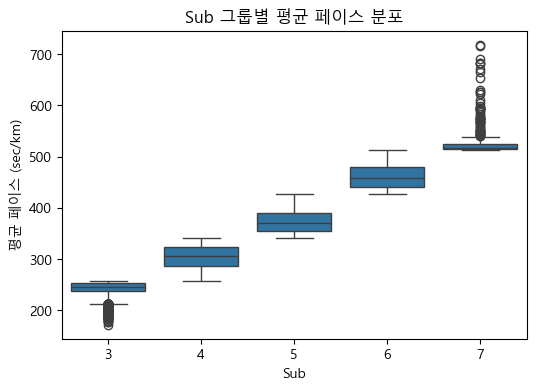

In [80]:
#1. Sub(목표 그룹)별 전체 완주 페이스 비교
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Sub', y=df['Final_Time'] / 42.195)
plt.ylabel('평균 페이스 (sec/km)')
plt.title('Sub 그룹별 평균 페이스 분포')
plt.show()

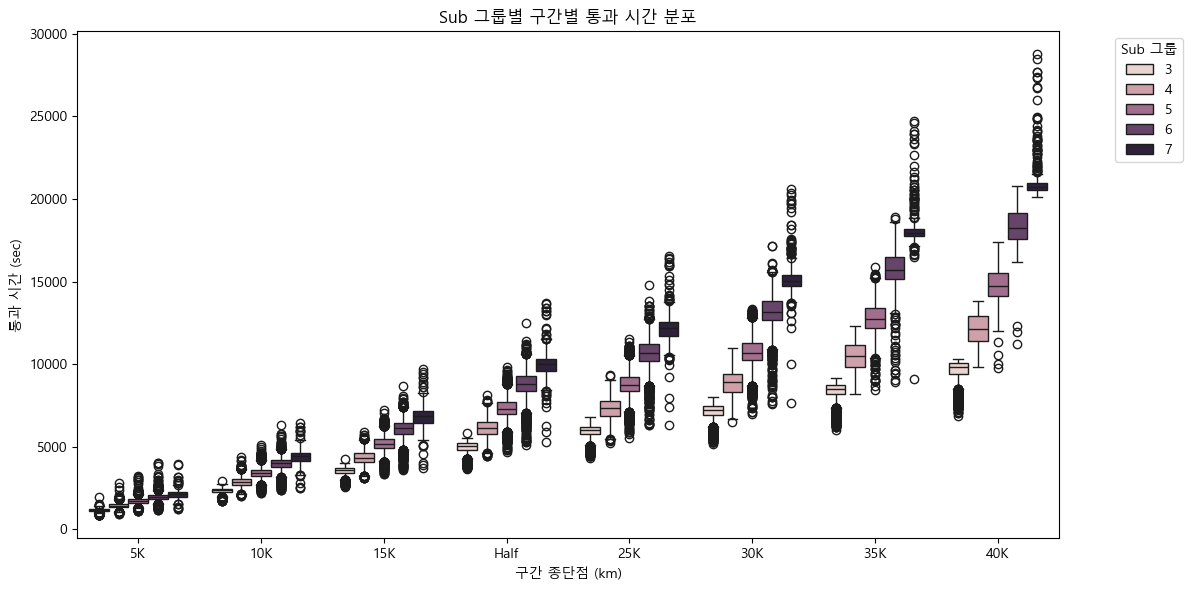

In [81]:
#2-2. Sub 그룹별 구간별 통과 시간 분포

# 1) 필요한 컬럼만 melt
segments = ['5K','10K','15K','Half','25K','30K','35K','40K']
df_melt = df.melt(
    id_vars='Sub',
    value_vars=segments,
    var_name='Segment',
    value_name='Time'
)

# 2) Segment 순서 지정
df_melt['Segment'] = pd.Categorical(
    df_melt['Segment'],
    categories=segments,
    ordered=True
)

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_melt,
    x='Segment', y='Time',
    hue='Sub'
)
plt.title('Sub 그룹별 구간별 통과 시간 분포')
plt.xlabel('구간 종단점 (km)')
plt.ylabel('통과 시간 (sec)')
plt.legend(title='Sub 그룹', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


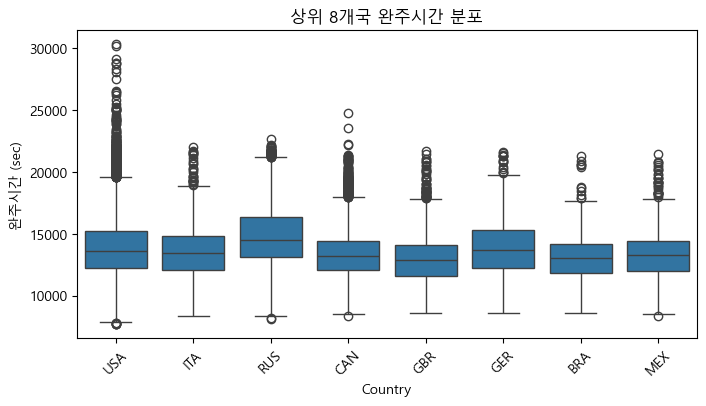

In [82]:
#3-1. 국가(Country)별 완주 기록 차이 (상위)
top_countries = df['Country'].value_counts().index[:8]
plt.figure(figsize=(8,4))
sns.boxplot(data=df[df['Country'].isin(top_countries)],
            x='Country', y='Final_Time')
plt.xticks(rotation=45)
plt.ylabel('완주시간 (sec)')
plt.title('상위 8개국 완주시간 분포')
plt.show()

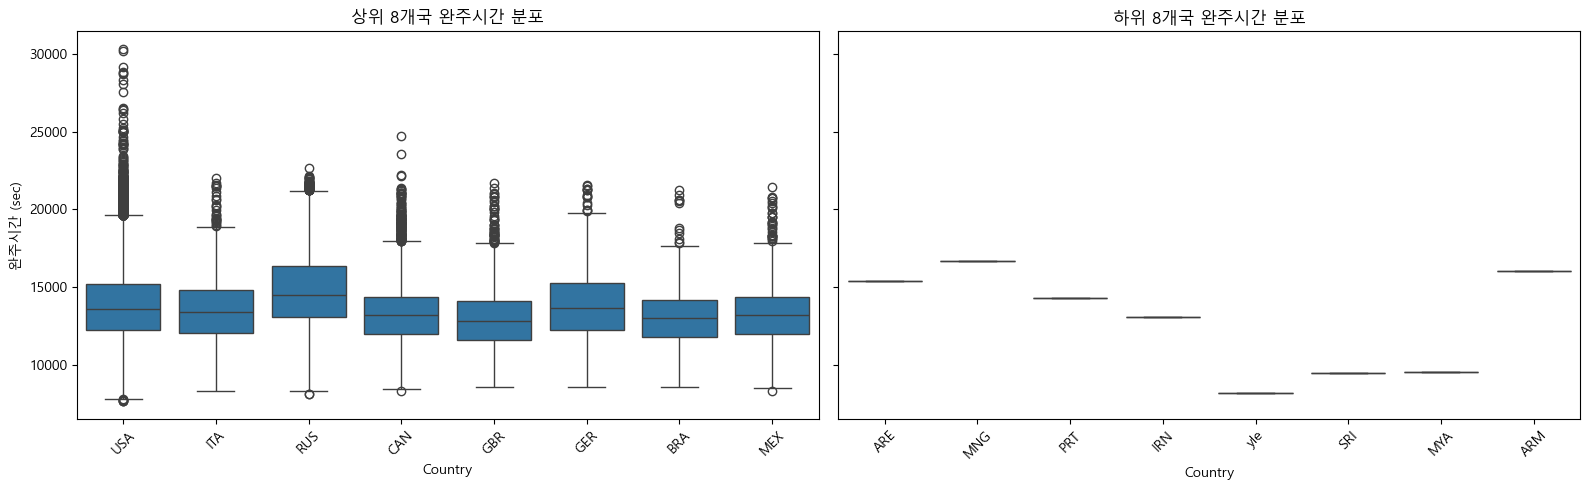

In [83]:
#3-2. 국가(Country)별 완주 기록 차이 (상하위)
# 1) 상위 8개국 / 하위 8개국 리스트 생성
country_counts = df['Country'].value_counts()
top8    = country_counts.index[:8]
bottom8 = country_counts.index[-8:]

# 2) 플롯 그리기
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# 상위 8개국
sns.boxplot(
    data=df[df['Country'].isin(top8)],
    x='Country', y='Final_Time',
    ax=axes[0]
)
axes[0].set_title('상위 8개국 완주시간 분포')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel('완주시간 (sec)')

# 하위 8개국
sns.boxplot(
    data=df[df['Country'].isin(bottom8)],
    x='Country', y='Final_Time',
    ax=axes[1]
)
axes[1].set_title('하위 8개국 완주시간 분포')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

동양 국가별 참가자 수:
Country
JPN    754
CHN    735
HKG    441
KOR    379
TPE    124
Name: count, dtype: int64


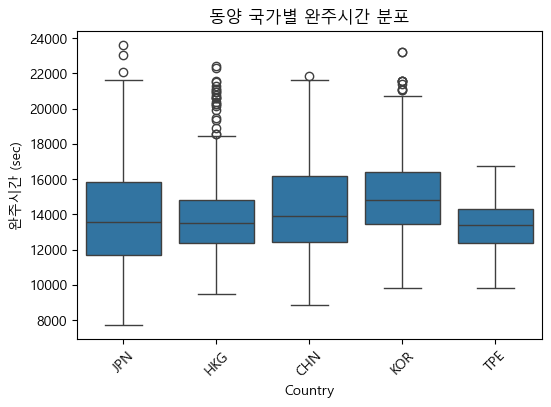

In [84]:
#3-3. 국가(Country)별 완주 기록 차이 (동양)
# 1) 동양 국가 코드 리스트 정의
eastern_countries = ['KOR', 'JPN', 'CHN', 'TPE', 'HKG']

# 2) 동양 국가만 필터링
df_east = df[df['Country'].isin(eastern_countries)].copy()

# 3) 간단히 참가자 수 확인
print("동양 국가별 참가자 수:")
print(df_east['Country'].value_counts())

# 4) 완주시간 분포 박스플롯
plt.figure(figsize=(6,4))
sns.boxplot(data=df_east, x='Country', y='Final_Time')
plt.xticks(rotation=45)
plt.title('동양 국가별 완주시간 분포')
plt.ylabel('완주시간 (sec)')
plt.show()


=== 그룹별 완주시간 기초통계 ===
             n     mean(sec)  median(sec)     std(sec)
group                                                 
Bottom       8  12838.000000      13683.5  3324.502970
East      2433  14224.325524      13817.0  2699.741940
Top     102193  13895.161841      13601.0  2389.588588


C:\Users\juhye\AppData\Local\Temp\ipykernel_21452\4202709939.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df3, x='group', y='Final_Time',


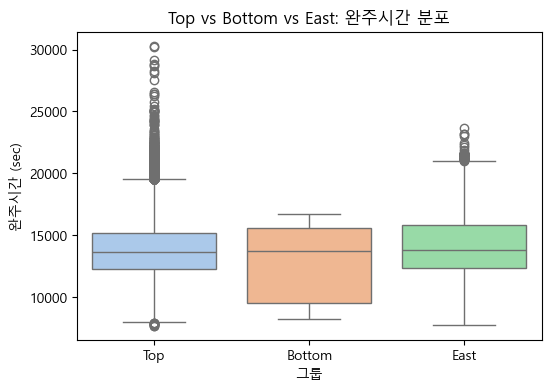

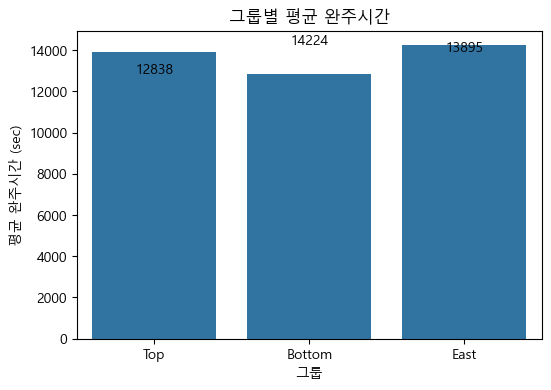

In [85]:
#3-4. 국가(Country)별 완주 기록 차이 (상위, 하위, 동양 비교)
# 1) 그룹별 국가 코드 정의
country_counts = df['Country'].value_counts()
top8    = set(country_counts.index[:8])
bottom8 = set(country_counts.index[-8:])
east_asia = {'KOR','JPN','CHN','TPE','HKG'}  # 필요시 더 추가

# 2) 각 행에 group 라벨 할당
def label_group(c):
    if c in top8:
        return 'Top'
    if c in bottom8:
        return 'Bottom'
    if c in east_asia:
        return 'East'
    return None

df['group'] = df['Country'].map(label_group)

# 3) 관심 있는 세 그룹만 필터
df3 = df[df['group'].notna()].copy()

# 4) 기초통계: 평균·중앙값·표준편차
stats = df3.groupby('group')['Final_Time'] \
           .agg(['count','mean','median','std']) \
           .rename(columns={'count':'n','mean':'mean(sec)','median':'median(sec)','std':'std(sec)'})
print("=== 그룹별 완주시간 기초통계 ===")
print(stats)

# 5) 박스플롯으로 분포 비교
plt.figure(figsize=(6,4))
sns.boxplot(data=df3, x='group', y='Final_Time',
            order=['Top','Bottom','East'],
            palette='pastel')
plt.title('Top vs Bottom vs East: 완주시간 분포')
plt.xlabel('그룹')
plt.ylabel('완주시간 (sec)')
plt.show()

# 6) 평균·중앙값 막대그래프
plt.figure(figsize=(6,4))
sns.barplot(x=stats.index, y=stats['mean(sec)'], order=['Top','Bottom','East'])
for i, v in enumerate(stats['mean(sec)']):
    plt.text(i, v+50, f"{v:.0f}", ha='center')
plt.title('그룹별 평균 완주시간')
plt.ylabel('평균 완주시간 (sec)')
plt.xlabel('그룹')
plt.show()



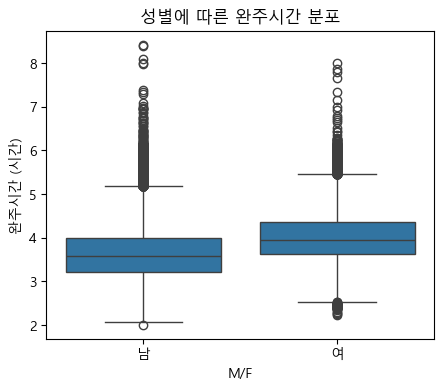

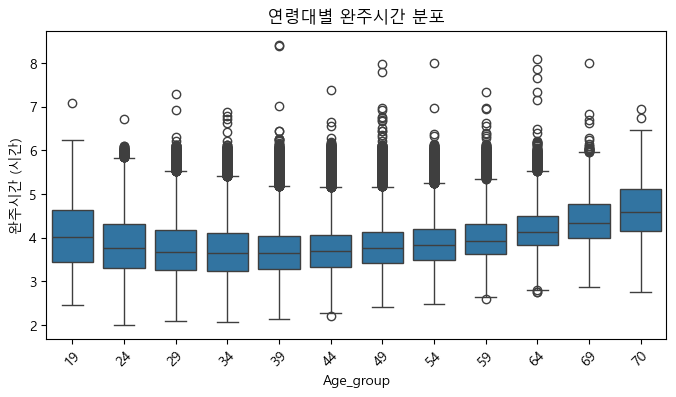

In [86]:
#4. 성별・연령대별 완주 페이스

# 1) Final_Time을 시간, 분 단위로 추가
df['Finish_Hours'] = df['Final_Time'] / 3600       # 시간 단위
df['Finish_Minutes'] = df['Final_Time'] / 60       # 분 단위

# ——— (A) 성별에 따른 완주시간 분포 ———
plt.figure(figsize=(5,4))
sns.boxplot(data=df, x='M/F', y='Finish_Hours')
plt.xticks([0,1], ['남','여'])
plt.ylabel('완주시간 (시간)')
plt.title('성별에 따른 완주시간 분포')
plt.show()

# ——— (B) 연령대에 따른 완주시간 분포 ———
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='Age_group', y='Finish_Hours')
plt.xticks(rotation=45)
plt.ylabel('완주시간 (시간)')
plt.title('연령대별 완주시간 분포')
plt.show()

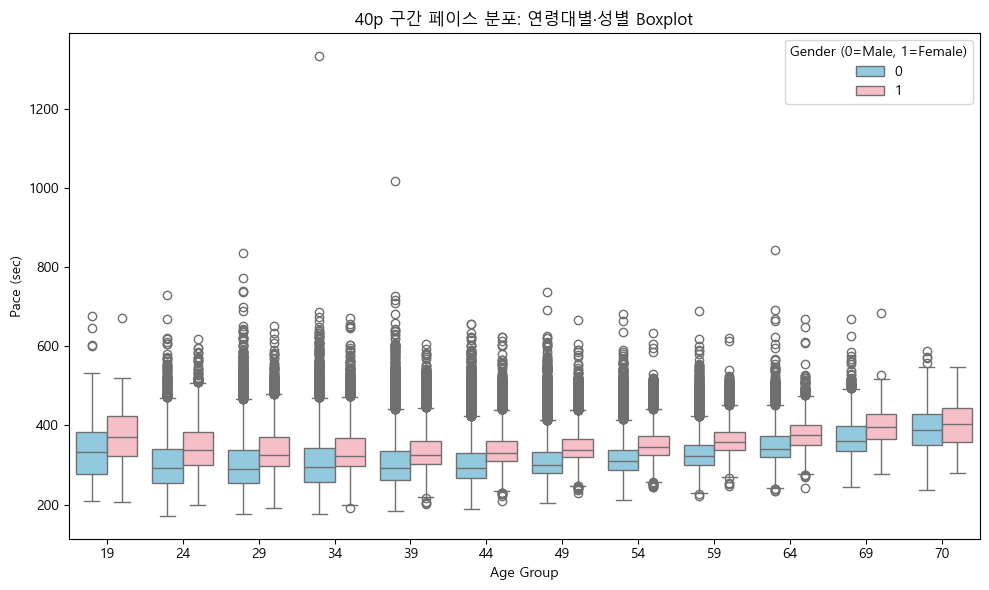

c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing 

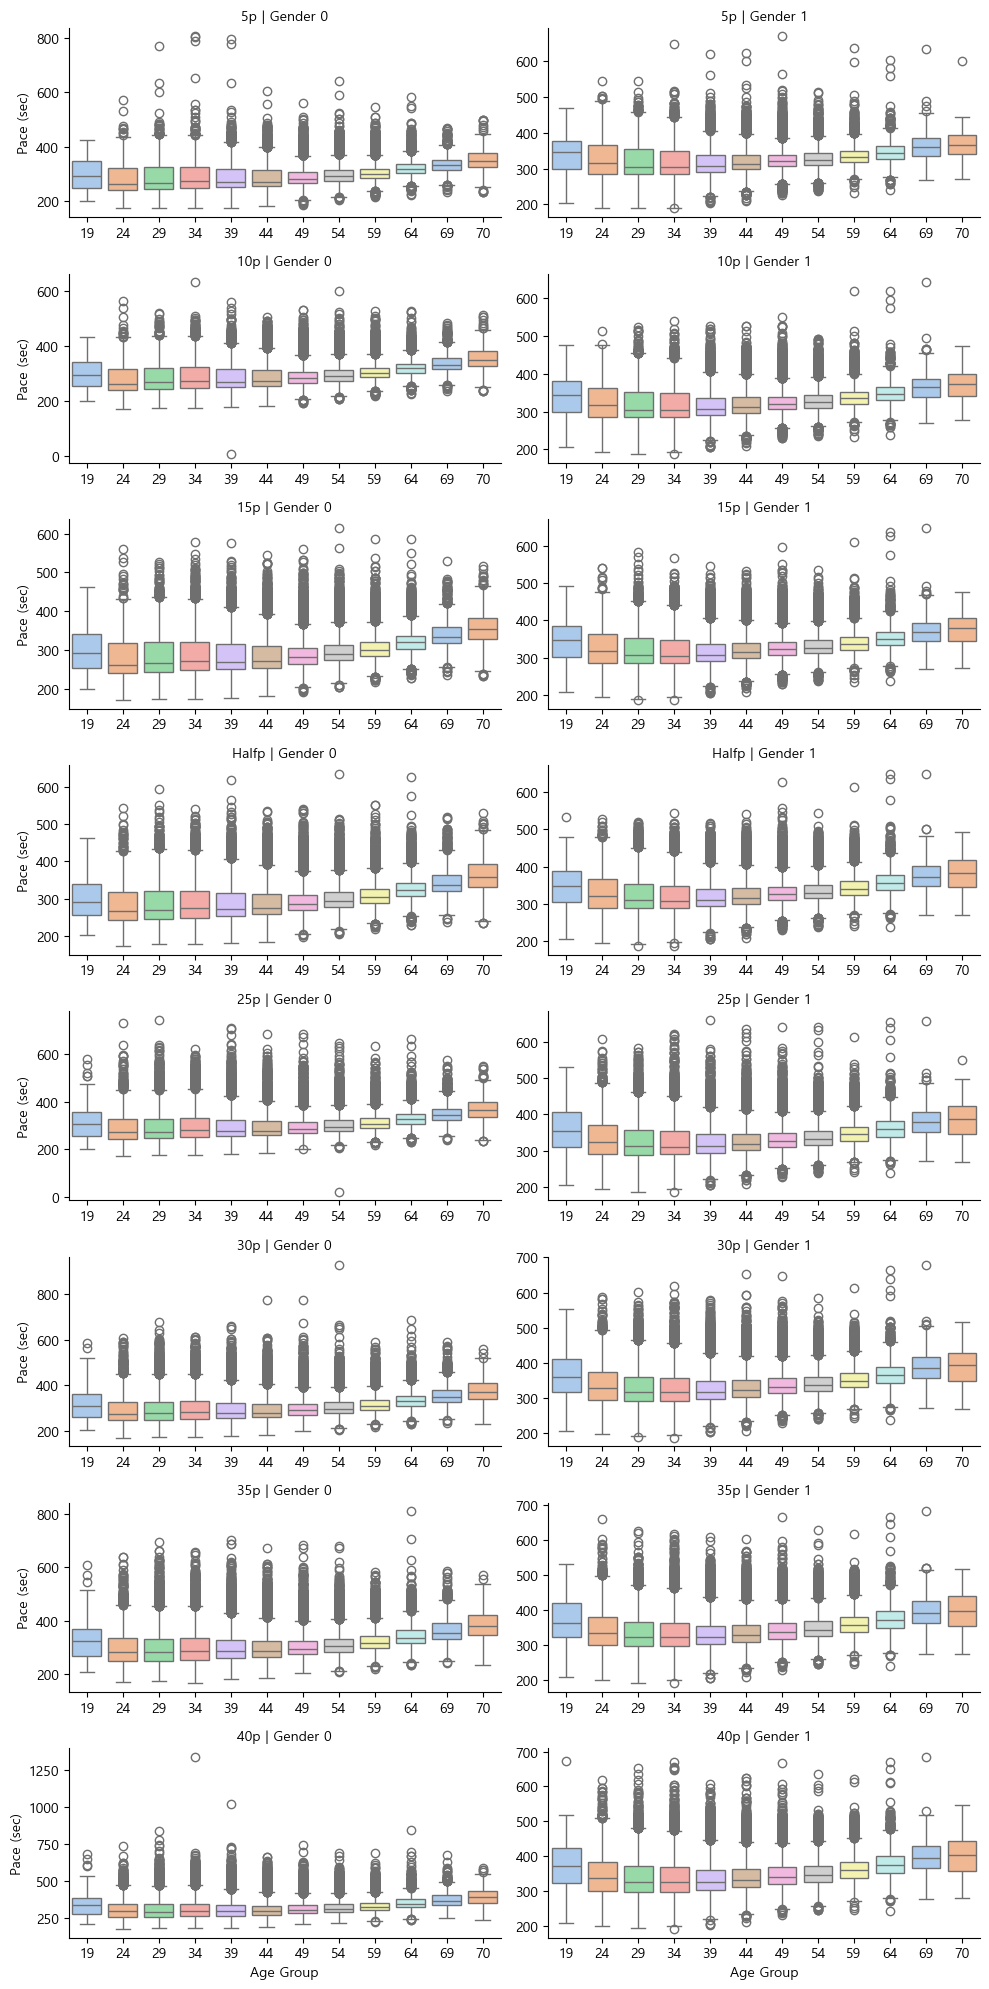


=== Segment × Age_group × Gender (std of Pace) ===
M/F                        0          1
Segment Age_group                      
10p     19         56.346832  53.454933
        24         53.533195  49.898483
        29         53.023336  47.905468
        34         52.193800  46.714055
        39         47.832557  41.121083
...                      ...        ...
Halfp   54         41.323093  36.099565
        59         38.727441  36.124610
        64         37.744788  38.561894
        69         39.540879  43.189958
        70         48.933226  50.581637

[96 rows x 2 columns]

=== Segment × Age_group t-test (Male vs Female) – Significant 여부 ===
Segment     10p   15p   25p   30p   35p    40p    5p  Halfp
Age_group                                                  
19         True  True  True  True  True   True  True   True
24         True  True  True  True  True   True  True   True
29         True  True  True  True  True   True  True   True
34         True  True  True  True  

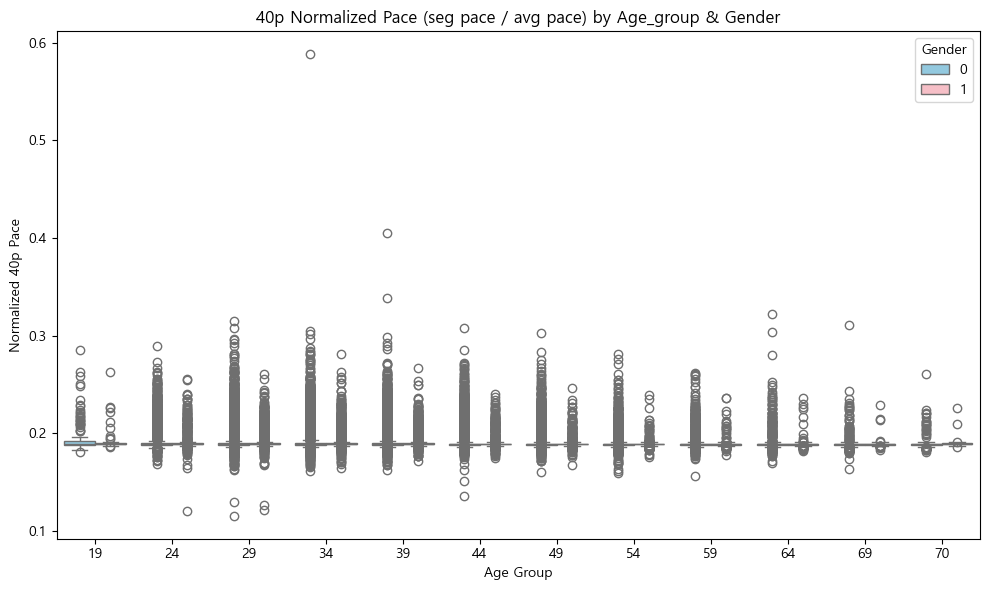


=== Normalized Pace by Age_group × Gender ===
                5p_norm  10p_norm  15p_norm  Halfp_norm  25p_norm  30p_norm  \
Age_group M/F                                                                 
19        0    0.174238  0.173392  0.174613    0.174931  0.182417  0.185069   
          1    0.174912  0.175118  0.176409    0.178808  0.183277  0.185674   
24        0    0.177205  0.176388  0.176746    0.177583  0.181946  0.184309   
          1    0.178897  0.178321  0.178956    0.180443  0.182776  0.185045   
29        0    0.179588  0.178770  0.178932    0.179281  0.183577  0.185205   
          1    0.180123  0.179878  0.180388    0.181568  0.183645  0.185504   
34        0    0.180031  0.179405  0.179599    0.179773  0.184490  0.185695   
          1    0.179725  0.179659  0.180266    0.181437  0.183831  0.185748   
39        0    0.179447  0.178861  0.179207    0.179747  0.183569  0.185040   
          1    0.179327  0.179170  0.179826    0.181119  0.183105  0.185175   
44   

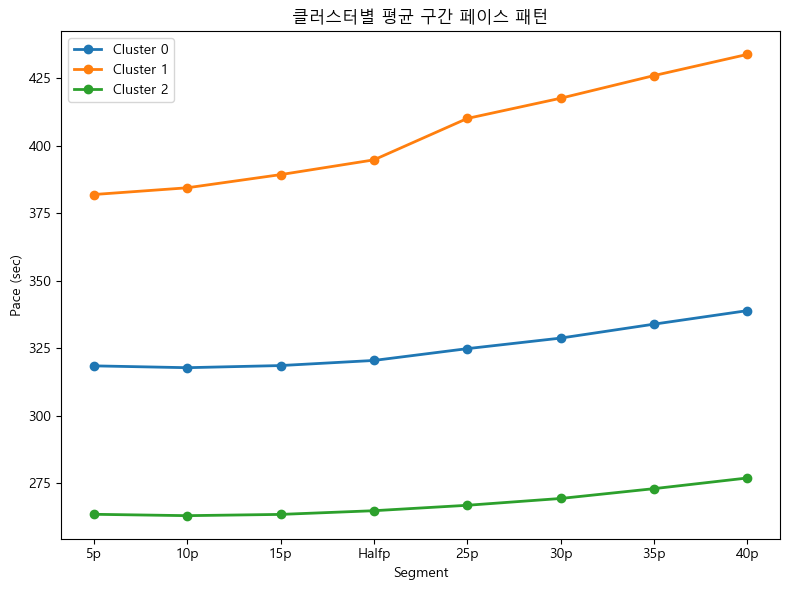

<Figure size 800x400 with 0 Axes>

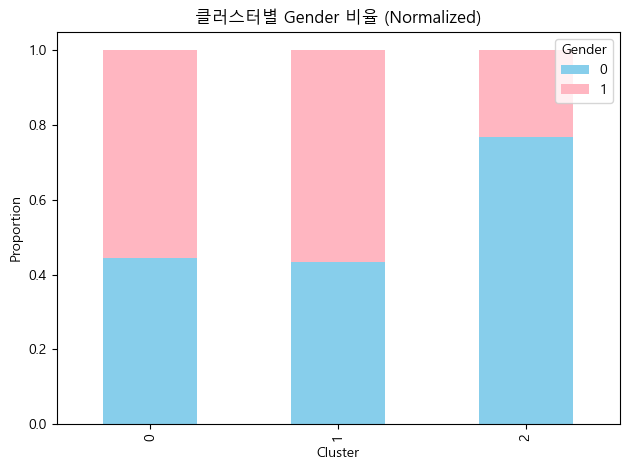

<Figure size 1000x600 with 0 Axes>

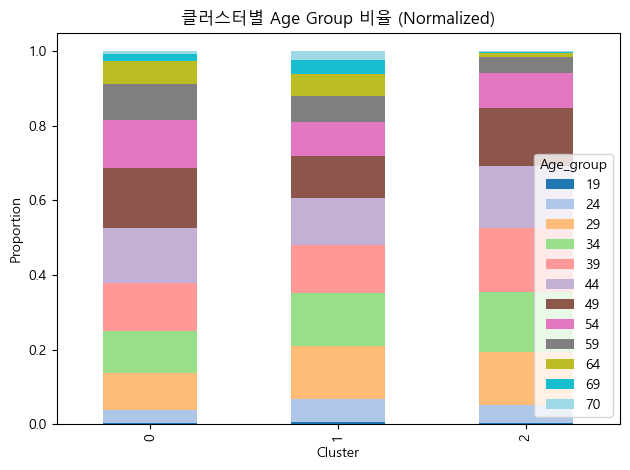

In [87]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#4-1. 성별 , 연령별 페이스 분석 advance

# 1) 구간별 페이스 컬럼 목록
pace_cols = ["5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p"]

# ——————————————————————————————————————————————————————————————
# 2) Boxplot: “연령대 × 성별” 구간별 페이스 분산 비교
# ——————————————————————————————————————————————————————————————

# 2-1) 데이터 긴 형태(Long Format)로 변환
df_long = df.melt(
    id_vars=["Age_group", "M/F"],
    value_vars=pace_cols,
    var_name="Segment",
    value_name="Pace"
)

# 2-2) 예시: 40p 구간 “연령대별·성별 Boxplot”
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_long[df_long["Segment"] == "40p"],
    x="Age_group",
    y="Pace",
    hue="M/F",
    palette=["skyblue", "lightpink"]
)
plt.title("40p 구간 페이스 분포: 연령대별·성별 Boxplot")
plt.xlabel("Age Group")
plt.ylabel("Pace (sec)")
plt.legend(title="Gender (0=Male, 1=Female)")
plt.tight_layout()
plt.show()

# 2-3) 모든 구간을 한 번에 보고 싶다면 FacetGrid 사용 (옵션)
g = sns.FacetGrid(
    df_long, 
    row="Segment", 
    col="M/F", 
    sharex=False, 
    sharey=False, 
    height=2.5, 
    aspect=2
)
g.map_dataframe(sns.boxplot, x="Age_group", y="Pace", palette="pastel")
g.set_axis_labels("Age Group", "Pace (sec)")
g.set_titles(row_template="{row_name}", col_template="Gender {col_name}")
plt.tight_layout()
plt.show()

# 2-4) 연령대·성별 구간별 표준편차 계산 & print
std_table = df_long.groupby(["Segment", "Age_group", "M/F"])["Pace"].std().unstack().fillna(0)
print("\n=== Segment × Age_group × Gender (std of Pace) ===")
print(std_table)


# ——————————————————————————————————————————————————————————————
# 3) 통계적 유의성 검정: “각 연령대별” 남녀 간 페이스 차이 (t-test)
# ——————————————————————————————————————————————————————————————
ttest_results = []
for seg in pace_cols:
    for age in sorted(df["Age_group"].unique()):
        male_vals = df[(df["M/F"] == 0) & (df["Age_group"] == age)][seg].dropna()
        female_vals = df[(df["M/F"] == 1) & (df["Age_group"] == age)][seg].dropna()
        # 최소 각 그룹 샘플 수 5개 이상 있어야 검정 가능
        if len(male_vals) >= 5 and len(female_vals) >= 5:
            tstat, pval = ttest_ind(male_vals, female_vals, equal_var=False)
            significant = (pval < 0.05)
            ttest_results.append({
                "Segment": seg,
                "Age_group": age,
                "p-value": pval,
                "Significant": significant
            })
        else:
            ttest_results.append({
                "Segment": seg,
                "Age_group": age,
                "p-value": np.nan,
                "Significant": False
            })

ttest_df = pd.DataFrame(ttest_results)
# 피벗 테이블 형태로 표시: index=Age_group, columns=Segment, 값은 “유의미 여부”
pivot_signif = ttest_df.pivot(
    index="Age_group",
    columns="Segment",
    values="Significant"
)
print("\n=== Segment × Age_group t-test (Male vs Female) – Significant 여부 ===")
print(pivot_signif)


# ——————————————————————————————————————————————————————————————
# 4) 회귀분석: “Age_group × 성별 상호작용” 검정 (예시: 40p 구간)
# ——————————————————————————————————————————————————————————————
df_reg = df.dropna(subset=["Age_group", "M/F", "40p"]).copy()

# OLS 회귀 모델: 40p ~ Age_group * (M/F)
model = smf.ols("Q('40p') ~ Age_group * Q('M/F')", data=df_reg).fit()

# 회귀 결과를 텍스트로 출력 (lxml 없이 가능)
print("\n=== Regression Summary: 40p Pace ~ Age_group * Gender ===")
print(model.summary())

# (원한다면 아래처럼 계수만 별도 출력 가능)
print("\n=== Coefficients ===")
print(model.params)
print("\n=== p-values ===")
print(model.pvalues)

# ——————————————————————————————————————————————————————————————
# 5) 정규화된 페이스 지표 생성 & 분석
#    - 세그먼트당 평균 페이스 = Final_Time / 8
#    - 정규화된 페이스 = 세그먼트 페이스 / (Final_Time/8)
# ——————————————————————————————————————————————————————————————
df_norm = df.dropna(subset=pace_cols + ["Final_Time"]).copy()
df_norm["Avg_per_segment"] = df_norm["Final_Time"] / 8

for seg in pace_cols:
    df_norm[f"{seg}_norm"] = df_norm[seg] / df_norm["Avg_per_segment"]

# 5-1) 40p_norm에 대한 연령대·성별 Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_norm,
    x="Age_group",
    y="40p_norm",
    hue="M/F",
    palette=["skyblue", "lightpink"]
)
plt.title("40p Normalized Pace (seg pace / avg pace) by Age_group & Gender")
plt.xlabel("Age Group")
plt.ylabel("Normalized 40p Pace")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# 5-2) 연령대×성별별 정규화된 페이스 평균 출력
norm_table = df_norm.groupby(["Age_group", "M/F"])[[f"{seg}_norm" for seg in pace_cols]].mean()
print("\n=== Normalized Pace by Age_group × Gender ===")
print(norm_table)

# ——————————————————————————————————————————————————————————————
# 6) 클러스터별(실력별) 연령·성별 패턴 비교
# ——————————————————————————————————————————————————————————————
df_cluster = df.dropna(subset=pace_cols + ["Final_Time", "Age_group", "M/F"]).copy()
X = df_cluster[pace_cols].values
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["pace_cluster"] = kmeans.fit_predict(X)

# 클러스터별 Age_group 분포 & Gender 분포 출력
cluster_age_dist = df_cluster.groupby(["pace_cluster", "Age_group"])["pace_cluster"].count().unstack(fill_value=0)
cluster_gender_dist = df_cluster.groupby(["pace_cluster", "M/F"])["pace_cluster"].count().unstack(fill_value=0)

print("\n=== Cluster × Age_group Distribution ===")
print(cluster_age_dist)
print("\n=== Cluster × Gender Distribution ===")
print(cluster_gender_dist)

# 클러스터별 평균 패턴 시각화
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=pace_cols)
cluster_centers["cluster"] = cluster_centers.index

plt.figure(figsize=(8, 6))
for i, row in cluster_centers.iterrows():
    plt.plot(
        pace_cols,
        row[pace_cols],
        marker="o",
        linewidth=2,
        label=f"Cluster {int(row['cluster'])}"
    )
plt.title("클러스터별 평균 구간 페이스 패턴")
plt.xlabel("Segment")
plt.ylabel("Pace (sec)")
plt.legend()
plt.tight_layout()
plt.show()

# 클러스터별 성별 비율 (정규화된 막대그래프)
cluster_gender_dist_norm = cluster_gender_dist.div(cluster_gender_dist.sum(axis=1), axis=0)
plt.figure(figsize=(8, 4))
cluster_gender_dist_norm.plot(
    kind="bar",
    stacked=True,
    color=["skyblue", "lightpink"]
)
plt.title("클러스터별 Gender 비율 (Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# 클러스터별 연령대 비율 (정규화된 막대그래프)
cluster_age_dist_norm = cluster_age_dist.div(cluster_age_dist.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
cluster_age_dist_norm.plot(kind="bar", stacked=True, colormap="tab20")
plt.title("클러스터별 Age Group 비율 (Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()


== 날씨·환경 vs 구간별 페이스 상관계수 ==
                        5p       10p       15p     Halfp       25p       30p  \
temperature_race -0.053325 -0.040555 -0.044228 -0.035302 -0.071942 -0.067643   
humidity_race     0.045791  0.022508  0.006003 -0.028437 -0.003394 -0.035574   

                       35p       40p  
temperature_race -0.068957 -0.075950  
humidity_race    -0.058692 -0.052946  


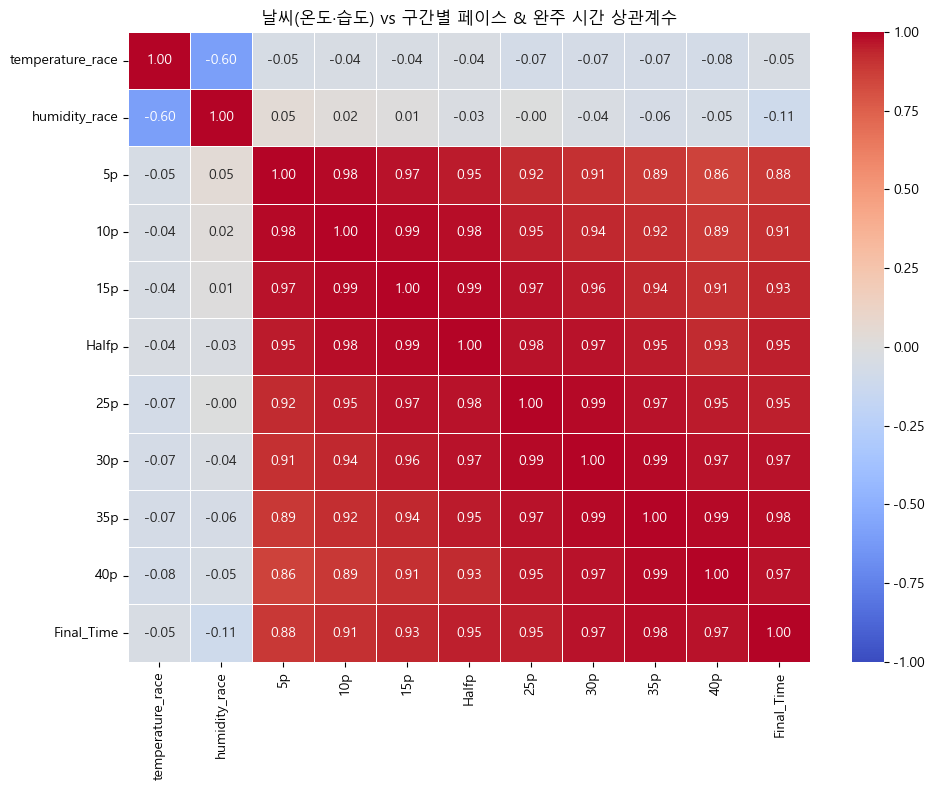

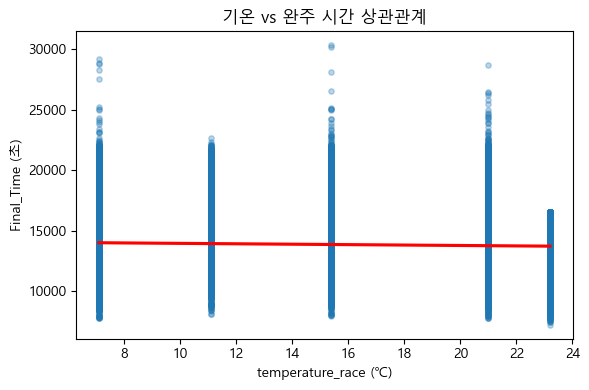

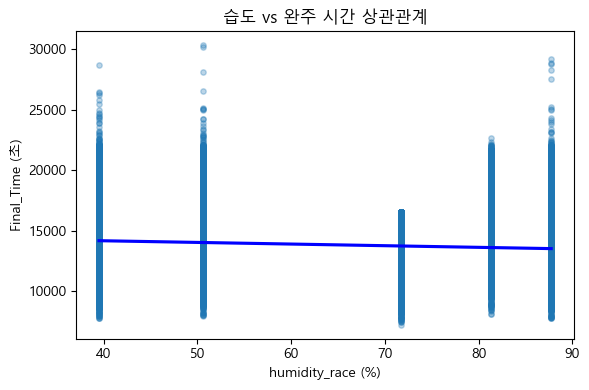

In [88]:
#5. 환경 변수(온도, 습도) vs 페이스 상관

#1) 상관계수 계산
corr_cols = ["temperature_race", "humidity_race", "5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p"]
corr_matrix = df[corr_cols].corr()
print("\n== 날씨·환경 vs 구간별 페이스 상관계수 ==")
print(corr_matrix.loc[["temperature_race", "humidity_race"], ["5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p"]])



# 2) 상관관계를 보고 싶은 컬럼들
corr_cols = [
    "temperature_race", "humidity_race",
    "5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p",
    "Final_Time"
]

# 3) 상관계수 계산
corr_matrix = df[corr_cols].corr()

# 4) 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,        # 셀에 숫자 표시
    fmt=".2f",         # 소수점 둘째 자리까지 표시
    cmap="coolwarm",   # 컬러맵 지정
    vmin=-1, vmax=1,   # 상관계수 범위
    linewidths=0.5,    # 셀 사이 경계선 두께
    linecolor="white"  # 셀 경계선 색상
)
plt.title("날씨(온도·습도) vs 구간별 페이스 & 완주 시간 상관계수")
plt.tight_layout()
plt.show()

# 5) 산점도 + 회귀선 (기온 vs 완주 시간)
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df,
    x="temperature_race",
    y="Final_Time",
    scatter_kws={"s": 15, "alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("기온 vs 완주 시간 상관관계")
plt.xlabel("temperature_race (℃)")
plt.ylabel("Final_Time (초)")
plt.tight_layout()
plt.show()

# 6) 산점도 + 회귀선 (습도 vs 완주 시간)
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df,
    x="humidity_race",
    y="Final_Time",
    scatter_kws={"s": 15, "alpha": 0.3},
    line_kws={"color": "blue"}
)
plt.title("습도 vs 완주 시간 상관관계")
plt.xlabel("humidity_race (%)")
plt.ylabel("Final_Time (초)")
plt.tight_layout()
plt.show()



=== 엘리트 그룹(Sub < 8000) 전체: 온도·습도 vs Final_Time 상관계수 ===
                  Final_Time
temperature_race   -0.045025
humidity_race      -0.105428


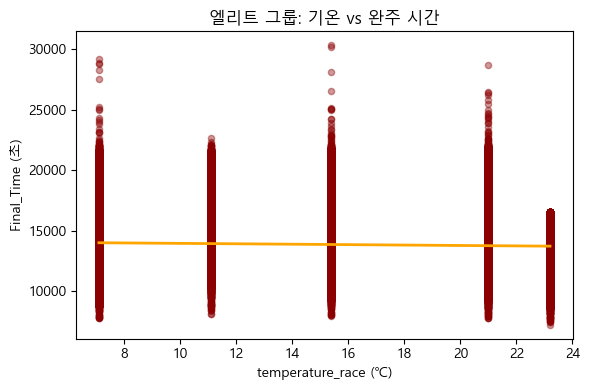

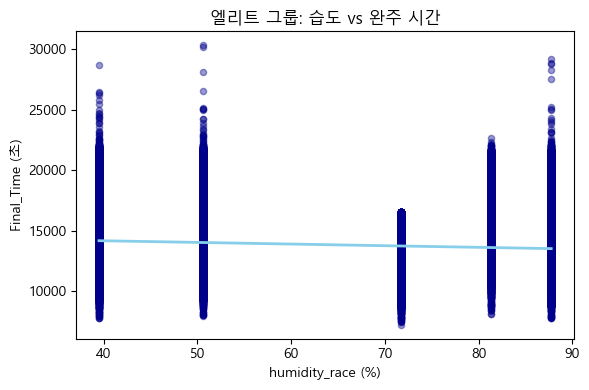

In [89]:
#5-1. 환경 변수(온도, 습도) vs 페이스 상관 advance
#비슷한 실력군으로 제한

race_list = df["Dataset"].unique()


# 1) 엘리트 그룹(Sub < 8000초) 분석
# -----------------------------------
elite_df = df[df["Sub"] < 8000].copy()
if not elite_df.empty:
    print("\n=== 엘리트 그룹(Sub < 8000) 전체: 온도·습도 vs Final_Time 상관계수 ===")
    corr_cols_elite = ["temperature_race", "humidity_race", "Final_Time"]
    corr_matrix_elite = elite_df[corr_cols_elite].corr()
    print(corr_matrix_elite.loc[["temperature_race", "humidity_race"], ["Final_Time"]])

    # (1) 기온 vs 완주 시간 (엘리트)
    plt.figure(figsize=(6, 4))
    sns.regplot(
        data=elite_df,
        x="temperature_race",
        y="Final_Time",
        scatter_kws={"s": 20, "alpha": 0.4, "color": "darkred"},
        line_kws={"color": "orange", "linewidth": 2}
    )
    plt.title("엘리트 그룹: 기온 vs 완주 시간")
    plt.xlabel("temperature_race (℃)")
    plt.ylabel("Final_Time (초)")
    plt.tight_layout()
    plt.show()

    # (2) 습도 vs 완주 시간 (엘리트)
    plt.figure(figsize=(6, 4))
    sns.regplot(
        data=elite_df,
        x="humidity_race",
        y="Final_Time",
        scatter_kws={"s": 20, "alpha": 0.4, "color": "darkblue"},
        line_kws={"color": "skyblue", "linewidth": 2}
    )
    plt.title("엘리트 그룹: 습도 vs 완주 시간")
    plt.xlabel("humidity_race (%)")
    plt.ylabel("Final_Time (초)")
    plt.tight_layout()
    plt.show()
else:
    print("엘리트 그룹(Sub < 8000) 데이터가 없습니다.")


In [71]:
# 6-1 도시(Dataset)별 평균 페이스 비교 (예: Boston vs 나머지)
city_stats = df.groupby("Dataset")[["5p", "40p"]].mean().reset_index()
print("\n== Dataset별(도시별) 5p & 40p 평균 페이스 ==")
print(city_stats)


== Dataset별(도시별) 5p & 40p 평균 페이스 ==
  Dataset          5p         40p
0       B  305.055986  329.646188
1       C  302.839560  309.342263
2       M  334.928580  388.619673


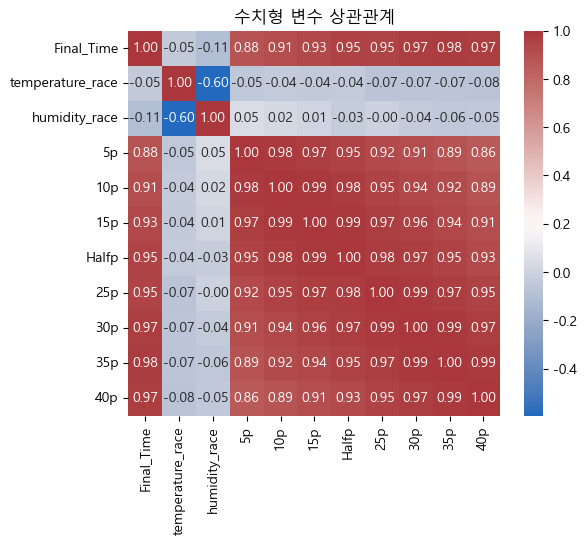

In [90]:
#7. 전체 수치형 Feature 상관관계 히트맵
num_cols = ['Final_Time', 'temperature_race','humidity_race'] + pace_cols
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='vlag')
plt.title('수치형 변수 상관관계')
plt.show()

1. 구간별 Pace 상관관계

5p,10p,…,40p (혹은 pace_*로 재계산했다면 그 값들) 가 서로 0.86~0.99 사이의 매우 높은 상관을 보입니다.

즉, 초반 페이스가 빠르면 거의 끝까지 일관되게 빠른 경향이 있습니다.

2. Final_Time vs Pace

모든 구간 Pace와 Final_Time(풀코스 총 완주 시간)은 0.89~0.98 의 매우 강한 양(+)의 상관을 가집니다.

전체 완주 시간은 곧 5km 구간 페이스들의 합(또는 평균)이므로 당연히 높게 나옵니다.

3. 온도·습도 영향

temperature_race 와 Final_Time 은 약 –0.09 (약한 음의 상관),

humidity_race 와 Final_Time 은 약 –0.07 로,

두 환경 변수는 페이스와도 거의 상관이 없습니다.

다만 온도와 습도끼리는 –0.97 로 매우 강한 음(–)의 상관을 보이는데, 이는 데이터 수집 환경(높은 온도일수록 상대습도가 낮게 기록됨)을 반영하는 듯합니다.

결론: 이 데이터에선 “누가 빠른지”는 전 구간 페이스가 강하게 묶여 있고, 환경 요인(온도·습도)은 페이스나 완주 시간에 미미한 영향만 줍니다.
따라서 모델에 넣을 때는 구간별 pace 와 Final_Time 은 중복 정보이니 하나만 쓰거나, PCA 등으로 차원 축소를 고려하는 게 좋습니다.

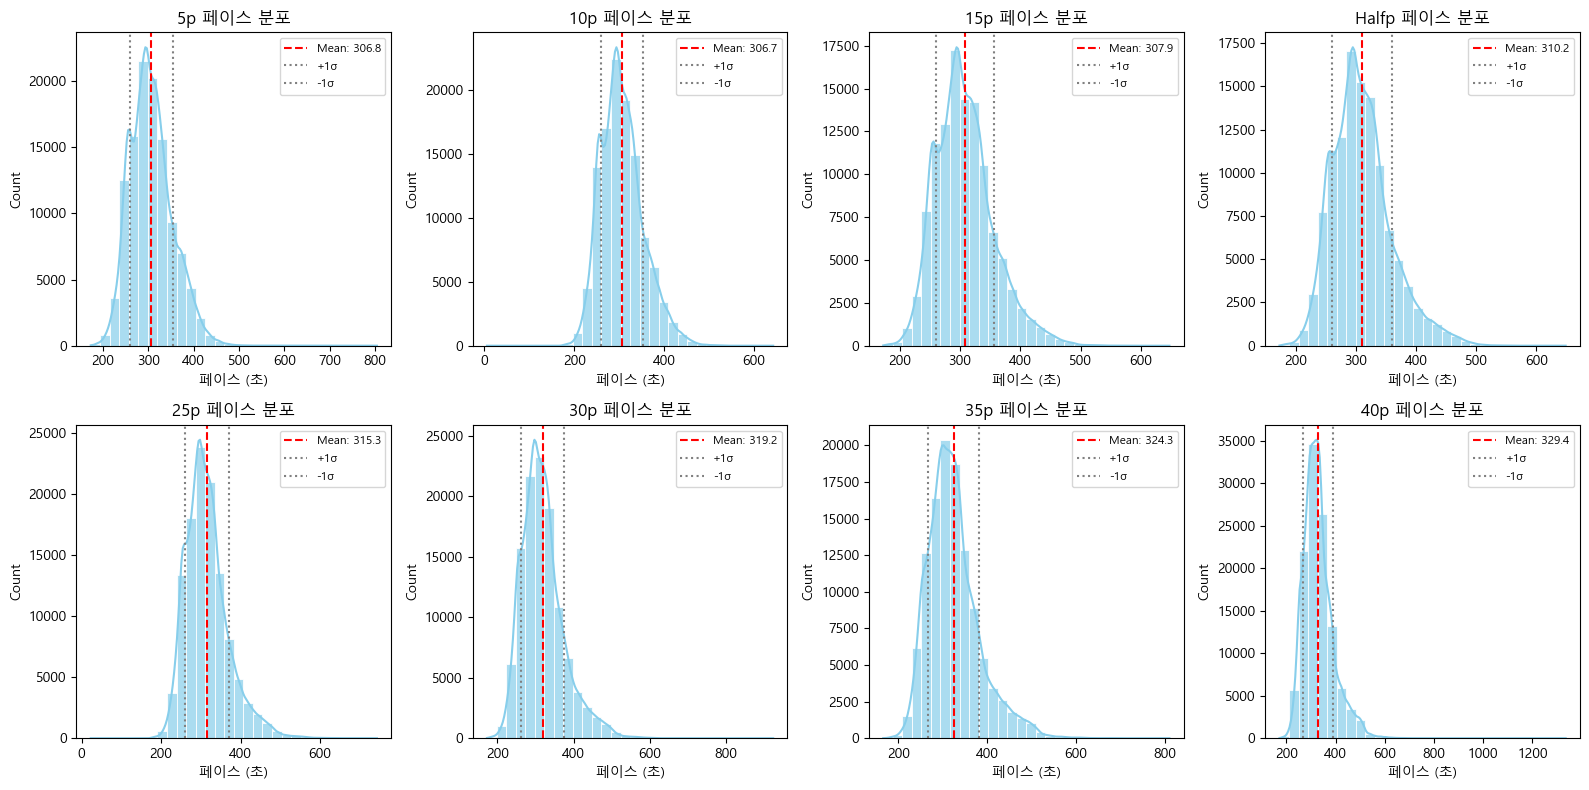

C:\Users\juhye\AppData\Local\Temp\ipykernel_21452\2297417502.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juhye\AppData\Local\Temp\ipykernel_21452\2297417502.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


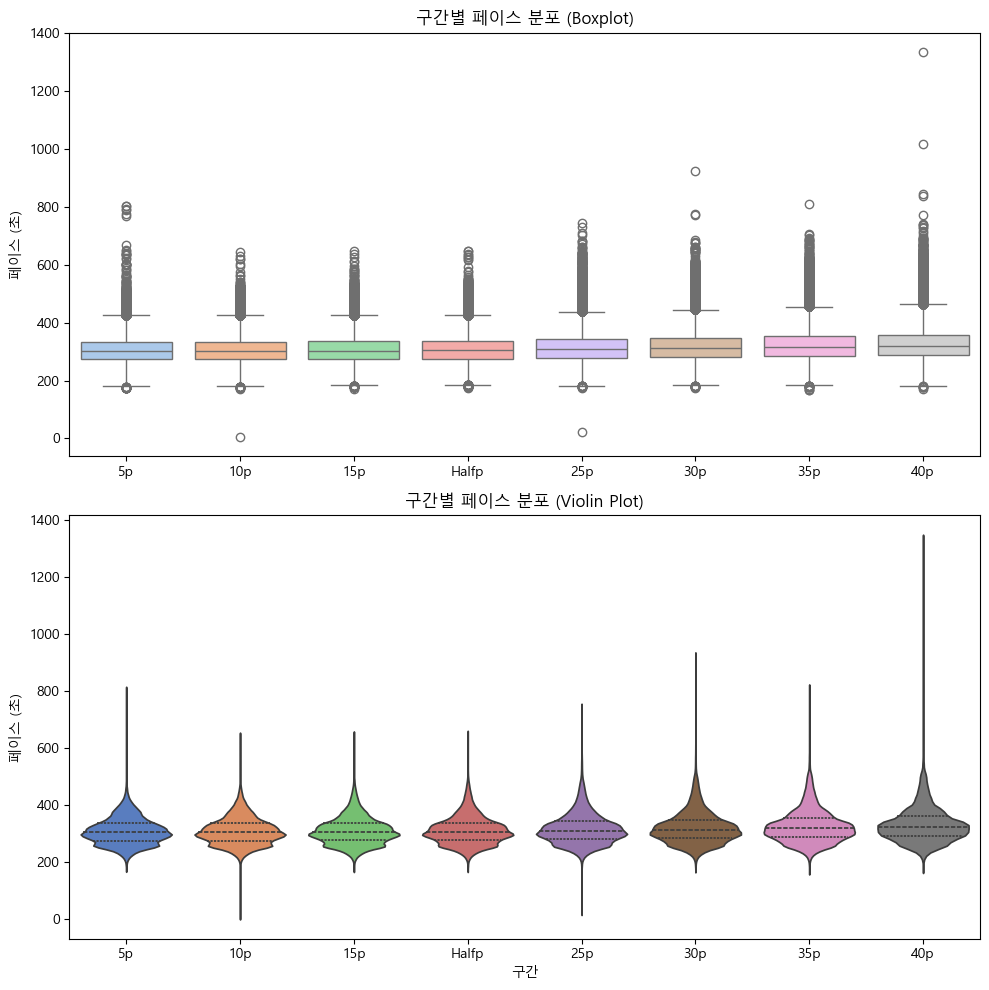

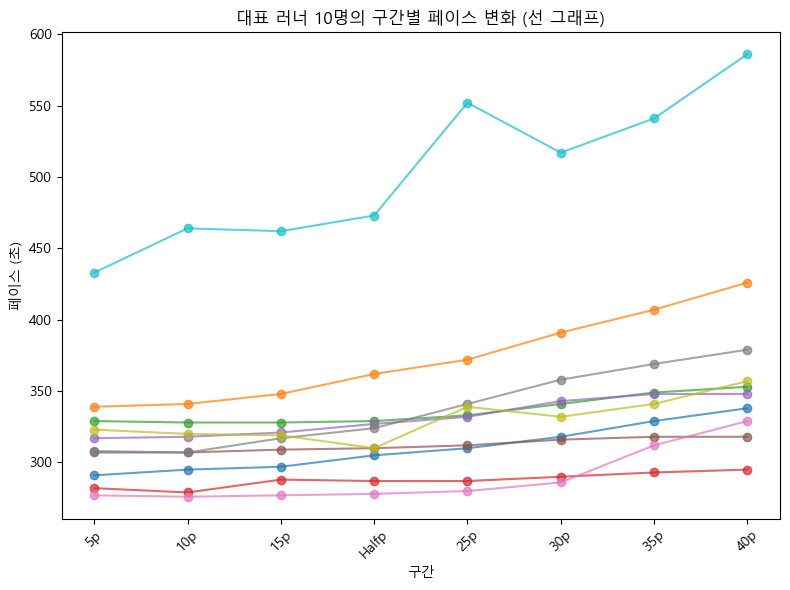

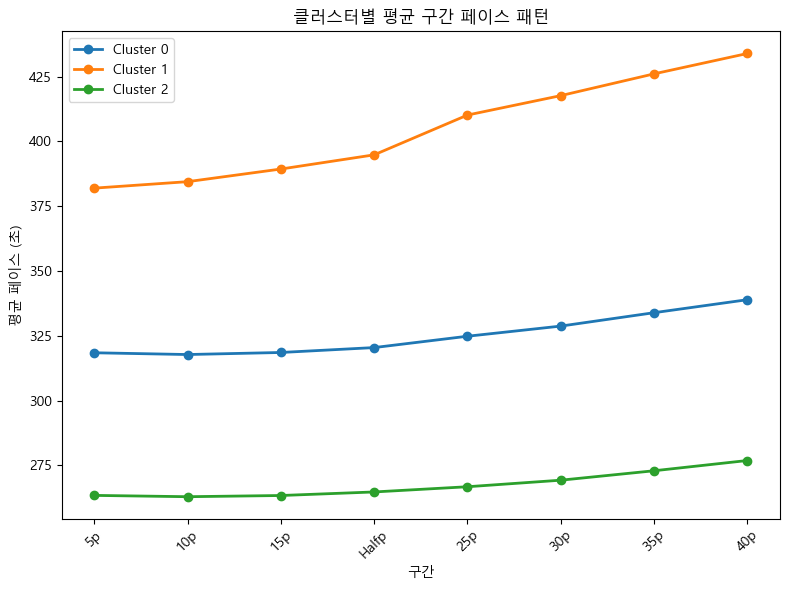

=== 클러스터별 완주시간 통계 ===
   pace_cluster     mean_time  median_time  count
0             0  14287.330311      14156.0  52384
1             1  17913.861698      17597.0  17498
2             2  11731.205887      11851.0  44607


C:\Users\juhye\AppData\Local\Temp\ipykernel_21452\2297417502.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


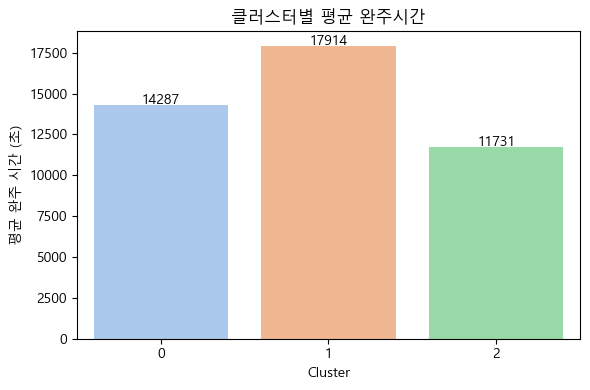

In [91]:
from sklearn.cluster import KMeans
#8 구간 간 페이스 변화 패턴 탐색

# 구간별 페이스 컬럼 목록
pace_cols = ["5p", "10p", "15p", "Halfp", "25p", "30p", "35p", "40p"]

# ——————————————————————————————————————————————————————————————
# 2) 페이스(속도) 분포 살펴보기
#    • 전체 구간별 히스토그램 + KDE
#    • 구간별 Boxplot, Violin Plot
#    → “구간이 진행될수록 평균·분산이 바뀐다” 증명
# ——————————————————————————————————————————————————————————————

# 2.1 히스토그램 + KDE (5p ~ 40p)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for ax, col in zip(axes, pace_cols):
    sns.histplot(
        data=df[col].dropna(),
        kde=True,
        bins=30,
        color="skyblue",
        edgecolor="white",
        alpha=0.7,
        ax=ax
    )
    mean_val = df[col].mean()
    std_val = df[col].std()
    ax.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:.1f}")
    ax.axvline(mean_val + std_val, color="gray", linestyle=":", label="+1σ")
    ax.axvline(mean_val - std_val, color="gray", linestyle=":", label="-1σ")
    ax.set_title(f"{col} 페이스 분포")
    ax.set_xlabel("페이스 (초)")
    ax.set_ylabel("Count")
    ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()


# 2.2 Boxplot & Violin Plot (모든 구간을 한 번에 비교)
#     데이터프레임을 “긴 형태(long form)”으로 변환
# Boxplot과 Violin Plot을 한 화면(2행 1열)으로 배치
df_long = df.melt(id_vars=[], value_vars=pace_cols, var_name="Segment", value_name="Pace")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# (1) Boxplot
sns.boxplot(
    data=df_long,
    x="Segment", y="Pace",
    palette="pastel",
    order=pace_cols,
    ax=axes[0]
)
axes[0].set_title("구간별 페이스 분포 (Boxplot)")
axes[0].set_xlabel("")
axes[0].set_ylabel("페이스 (초)")

# (2) Violin Plot
sns.violinplot(
    data=df_long,
    x="Segment", y="Pace",
    inner="quartile",
    palette="muted",
    order=pace_cols,
    ax=axes[1]
)
axes[1].set_title("구간별 페이스 분포 (Violin Plot)")
axes[1].set_xlabel("구간")
axes[1].set_ylabel("페이스 (초)")

plt.tight_layout()
plt.show()



# ——————————————————————————————————————————————————————————————
# 3) 구간 간 페이스 변화 패턴 탐색
#    • 3.1) 대표 샘플 10명 꺾은선 그래프
#    • 3.2) KMeans 클러스터링 → 클러스터별 평균 페이스곡선 + 완주시간 비교
# ——————————————————————————————————————————————————————————————

# 3.1 대표 샘플 10명 (결측치 없는 러너 중 랜덤 선택)
sample_runners = df.dropna(subset=pace_cols).sample(n=10, random_state=42)

plt.figure(figsize=(8, 6))
for _, row in sample_runners.iterrows():
    pace_values = row[pace_cols].values.astype(float)
    plt.plot(
        pace_cols,
        pace_values,
        marker="o",
        alpha=0.7,
        linewidth=1.5
    )
plt.title("대표 러너 10명의 구간별 페이스 변화 (선 그래프)")
plt.xlabel("구간")
plt.ylabel("페이스 (초)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3.2 클러스터링 (KMeans)
# ——————————————————————————————————————————————————————————————
# ① 클러스터링용 데이터: 결측치 제거 후 구간별 페이스 데이터만 사용
df_cluster = df.dropna(subset=pace_cols).copy()
X = df_cluster[pace_cols].values  # (N, 8) 행렬

# ② KMeans 모델 학습 (클러스터 개수는 상황에 맞춰 조정 가능)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["pace_cluster"] = kmeans.fit_predict(X)

# ③ 클러스터별 평균 구간 페이스(centroid) 추출
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=pace_cols
)
cluster_centers["cluster"] = cluster_centers.index

plt.figure(figsize=(8, 6))
for i, row in cluster_centers.iterrows():
    plt.plot(
        pace_cols,
        row[pace_cols],
        marker="o",
        linewidth=2,
        label=f"Cluster {int(row['cluster'])}"
    )
plt.title("클러스터별 평균 구간 페이스 패턴")
plt.xlabel("구간")
plt.ylabel("평균 페이스 (초)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ④ 클러스터별 완주시간 통계 비교
cluster_stats = df_cluster.groupby("pace_cluster")["Final_Time"].agg(
    mean_time="mean",
    median_time="median",
    count="count"
).reset_index()
print("=== 클러스터별 완주시간 통계 ===")
print(cluster_stats)

# 클러스터별 평균 완주시간 막대그래프
plt.figure(figsize=(6, 4))
sns.barplot(
    data=cluster_stats,
    x="pace_cluster",
    y="mean_time",
    palette="pastel"
)
for idx, val in enumerate(cluster_stats["mean_time"]):
    plt.text(idx, val + 50, f"{val:.0f}", ha="center")
plt.title("클러스터별 평균 완주시간")
plt.xlabel("Cluster")
plt.ylabel("평균 완주 시간 (초)")
plt.tight_layout()
plt.show()

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# 1) Sub-3 검증 데이터 확보 (예: Sub == 3)
df_sub3 = df[df['Sub'] == 3].reset_index(drop=True)

# 2) 특성 및 타깃 정의
#   X: 신체정보, 목표그룹(Sub), 환경요인, 보스턴 고도 가중치(wt_*)
feature_cols = [
    'M/F',          # 성별 (0=남,1=여)
    'Age_group',    # 연령대
    'Sub',          # 목표 그룹
    'temperature_race',
    'humidity_race',
    # 보스턴만 값이 들어있는 wt_컬럼 (없으면 NaN→0 처리 필요)
    'wt_5K', 'wt_10K', 'wt_15K', 'wt_20K',
    'wt_25K', 'wt_30K', 'wt_35K', 'wt_40K'
]

#   Y: 5km 구간별 페이스(초/km)
target_cols = ['5p','10p','15p','Halfp','25p','30p','35p','40p']

#-------------------------------------------

X = df_sub3[feature_cols].fillna(0)   # NaN 이 있으면 0 으로 대체
Y = df_sub3[target_cols].fillna(0)

# 3) 학습/검증 분할
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 4) 파이프라인 구성 (스케일링 + 다중출력 회귀)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MultiOutputRegressor(
        RandomForestRegressor(n_estimators=100, random_state=42)
    ))
])

# 5) 학습
pipeline.fit(X_train, Y_train)

# 6) 검증
Y_pred = pipeline.predict(X_val)

print("=== 구간별 MAE & R² ===")
for i, col in enumerate(target_cols):
    mae = mean_absolute_error(Y_val.iloc[:, i], Y_pred[:, i])
    r2  = r2_score(Y_val.iloc[:, i],    Y_pred[:, i])
    print(f"{col}: MAE={mae:.2f} sec/km,  R²={r2:.3f}")

# 7) 예측 예시: 30세 남성, Sub-3, 10℃·80% 습도, 보스턴 고도 가중치 적용
example = pd.DataFrame([{
    'M/F': 0,
    'Age_group': 30,
    'Sub': 3,
    'temperature_race': 10,
    'humidity_race': 80,
    'wt_5K':  -77,
    'wt_10K': -17,
    'wt_15K':  -9,
    'wt_20K':   0,
    'wt_25K': -6,
    'wt_30K': -22,
    'wt_35K': +22,
    'wt_40K': -22
}])
pred = pipeline.predict(example)
print("\n예측된 구간별 페이스(sec/km):")
print(dict(zip(target_cols, pred[0])))


=== 구간별 MAE & R² ===
5p: MAE=12.12 sec/km,  R²=0.041
10p: MAE=11.19 sec/km,  R²=0.061
15p: MAE=10.72 sec/km,  R²=0.073
Halfp: MAE=10.38 sec/km,  R²=0.072
25p: MAE=10.17 sec/km,  R²=0.104
30p: MAE=9.88 sec/km,  R²=0.072
35p: MAE=9.66 sec/km,  R²=0.066
40p: MAE=9.58 sec/km,  R²=0.080

예측된 구간별 페이스(sec/km):
{'5p': 235.72560964561225, '10p': 234.94282553767283, '15p': 234.37546714886892, 'Halfp': 233.1446149222523, '25p': 237.923271923907, '30p': 237.53441266881916, '35p': 237.95680797037082, '40p': 239.65931184996523}


# 학습을 위한 데이터셋 가공

In [92]:
import pandas as pd
import numpy as np

def preprocess_age_group(age_group_series: pd.Series) -> pd.Series:
    """'Age_group' 문자열을 대표 숫자 나이로 변환합니다."""
    def convert_age(ag_str):
        ag_str = str(ag_str).strip() # 문자열로 변환하고 공백 제거
        if ag_str == '19': # 19세 이하
            return 18 # 또는 19
        elif ag_str == '70': # 70세 이상
            return 72 # 또는 70
        elif len(ag_str) == 2 and ag_str.isdigit(): # 예: '29' (25-29세), '34' (30-34세)
            upper_bound = int(ag_str)
            lower_bound = upper_bound - 4
            return (lower_bound + upper_bound) / 2
        else:
            return np.nan # 그 외 알 수 없는 값
    return age_group_series.apply(convert_age)

def prepare_model_ready_data(input_csv_path: str, output_csv_path: str):
    """
    FINAL_marathons_with_weather.csv 파일을 읽어 모델 학습에 필요한
    최종 특성 및 목표 변수를 만들고 정제하여 새 CSV로 저장합니다.
    """
    try:
        print(f"'{input_csv_path}' 파일 로딩 중...")
        df = pd.read_csv(input_csv_path, low_memory=False)
        print("파일 로딩 완료.")
    except FileNotFoundError:
        print(f"FATAL Error: 입력 파일 '{input_csv_path}'을(를) 찾을 수 없습니다.")
        return
    except Exception as e:
        print(f"FATAL Error: 파일 로딩 중 오류 발생 - {e}")
        return

    # --- 1. Age_group 처리 ---
    if 'Age_group' in df.columns:
        df['age_numeric'] = preprocess_age_group(df['Age_group'])
        print("'Age_group'을 'age_numeric'으로 변환 완료.")
    else:
        print("Warning: 'Age_group' 컬럼이 없습니다.")
        df['age_numeric'] = np.nan # 컬럼이 없으면 NaN으로 생성

    # --- 2. 목표 변수 (구간별 페이스) 정의 및 생성 ---
    # 기존 Xp 컬럼들을 목표 변수로 사용하고, 이름 변경
    # (5p, 10p, 15p, Halfp, 25p, 30p, 35p, 40p 순서로 가정)
    # Halfp는 어느 구간인지 명확한 정의가 필요하나, 일단 그대로 사용
    pace_target_cols_original = ['5p', '10p', '15p', 'Halfp', '25p', '30p', '35p', '40p']
    pace_target_cols_new = [
        'target_pace_0_5km', 'target_pace_5_10km', 'target_pace_10_15km', 
        'target_pace_15_Half', 
        'target_pace_Half_25km',
        'target_pace_25_30km', 'target_pace_30_35km', 'target_pace_35_40km'
    ]

    # 실제 존재하는 컬럼만 이름 변경 시도
    rename_dict = {}
    for old, new in zip(pace_target_cols_original, pace_target_cols_new):
        if old in df.columns:
            rename_dict[old] = new
        else:
            print(f"Warning: 목표 변수용 페이스 컬럼 '{old}'가 원본 데이터에 없습니다. 해당 목표 변수는 생성되지 않습니다.")
    df.rename(columns=rename_dict, inplace=True)
    
    # 마지막 구간 (40km ~ 완주) 페이스 계산
    # 풀코스 거리 정의 (km)
    FULL_MARATHON_DISTANCE_KM = 42.195 
    if 'Final_Time' in df.columns and '40K' in df.columns:
        # 40km 이후 남은 거리 (km)
        remaining_distance_km = FULL_MARATHON_DISTANCE_KM - 40.0
        # 40km 이후 걸린 시간 (sec)
        time_after_40k_sec = df['Final_Time'] - df['40K']
        # 40km 이후 페이스 (sec/km)
        # 남은 거리가 0보다 크고, 시간도 양수인 경우에만 계산
        df['target_pace_40_finish'] = np.where(
            (remaining_distance_km > 0) & (time_after_40k_sec >= 0) & (df['40K'] <= df['Final_Time']),
            time_after_40k_sec / remaining_distance_km,
            np.nan
        )
        pace_target_cols_new.append('target_pace_40_finish')
        print("마지막 구간(40km-완주) 페이스 계산 완료.")
    else:
        print("Warning: 'Final_Time' 또는 '40K' 컬럼이 없어 마지막 구간 페이스를 계산할 수 없습니다.")

    # 생성된 실제 목표 변수 컬럼 목록
    final_pace_target_columns = [col for col in pace_target_cols_new if col in df.columns]
    if not final_pace_target_columns:
        print("Error: 생성된 목표 페이스 변수가 하나도 없습니다. Xp 또는 XK 컬럼명을 확인해주세요.")


    # --- 3. 입력 특성(X) 선택 및 가공 ---
    # 사용자 입력 플레이스홀더 추가 (모델 학습 시에는 NaN 또는 특정값으로, 예측 시에는 사용자 입력 사용)
    df['user_weekly_km'] = np.nan # 사용자가 입력할 주간 평균 달리기 거리
    df['user_target_time_sec'] = np.nan # 사용자가 입력할 목표 완주 시간 (초)

    feature_columns = [
        'age_numeric', 
        'M/F', # 이미 0/1로 인코딩 되어있다고 가정
        'Dataset', # 범주형 -> 원-핫 인코딩 필요
        'Year', 
        'temperature_race', 
        'humidity_race',
        'Sub', # 범주형 -> 원-핫 인코딩 필요
        'user_weekly_km',
        'user_target_time_sec'
    ]
    
    # 실제 존재하는 특성 컬럼만 선택
    existing_feature_columns = [col for col in feature_columns if col in df.columns]
    if len(existing_feature_columns) != len(feature_columns):
        print(f"Warning: 일부 기본 특성 컬럼이 원본 데이터에 없습니다. 있는 컬럼만 사용합니다: {existing_feature_columns}")

    # 최종 사용할 특성과 목표 변수만 선택
    df_model_ready = df[existing_feature_columns + final_pace_target_columns].copy()

    # 범주형 변수 원-핫 인코딩 (Dataset, Sub)
    categorical_cols = []
    if 'Dataset' in df_model_ready.columns: categorical_cols.append('Dataset')
    if 'Sub' in df_model_ready.columns: categorical_cols.append('Sub')
    
    if categorical_cols:
        df_model_ready = pd.get_dummies(df_model_ready, columns=categorical_cols, dummy_na=False) # dummy_na=False: NaN에 대한 더미 변수 생성 안함
        print(f"범주형 변수 {categorical_cols} 원-핫 인코딩 완료.")
    
    # --- 4. 결측치 처리 ---
    # 목표 변수에 결측치가 있는 행은 예측/학습이 불가능하므로 우선 제거 (또는 다른 정교한 처리)
    if final_pace_target_columns:
        # 모든 목표 페이스 컬럼에 대해 결측치가 없는 행만 남기거나, 일부만 있는 경우도 고려 가능
        # 여기서는 가장 중요한 첫번째 목표 페이스 컬럼이 NaN인 경우만 우선 제거
        # 또는, 모든 목표 페이스가 NaN인 경우 제거
        # df_model_ready.dropna(subset=final_pace_target_columns, how='all', inplace=True)
        # 혹은, 주요 페이스 (예: 첫 구간)에 NaN이 있으면 제거
        if final_pace_target_columns[0] in df_model_ready.columns:
             df_model_ready.dropna(subset=[final_pace_target_columns[0]], inplace=True)


    # 입력 특성(X)의 결측치 처리 (예: 수치형은 평균 또는 중앙값, 범주형은 최빈값 - 여기서는 OHE 후이므로 숫자형만 해당)
    for col in existing_feature_columns: # OHE로 인해 컬럼명 변경될 수 있으므로, OHE 전 컬럼명 기준
        if col in df_model_ready.columns and df_model_ready[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_model_ready[col]):
                median_val = df_model_ready[col].median()
                df_model_ready[col].fillna(median_val, inplace=True)
                print(f"'{col}' 컬럼의 결측치를 중앙값 ({median_val:.2f})으로 채웠습니다.")
            # else: # 범주형 결측치 (OHE 전이었다면 최빈값 등으로 처리)
                # mode_val = df_model_ready[col].mode()[0]
                # df_model_ready[col].fillna(mode_val, inplace=True)

    print("결측치 처리 완료 (목표변수 NaN 행 일부 제거, 특성 NaN 중앙값 대체).")
    
    # --- 5. 최종 데이터 저장 ---
    try:
        # 저장 경로의 디렉토리 확인 및 생성
        output_dir_path = os.path.dirname(output_csv_path)
        if output_dir_path and not os.path.exists(output_dir_path):
            os.makedirs(output_dir_path)
            print(f"출력 디렉토리 '{output_dir_path}' 생성 완료.")
            
        df_model_ready.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
        print(f"\n모델 학습 준비 완료된 데이터가 '{output_csv_path}'에 저장되었습니다.")
        print("\n최종 데이터 정보 (model_ready_data):")
        df_model_ready.info()
        print("\n최종 데이터 상위 5행 (model_ready_data):")
        print(df_model_ready.head())
        
    except Exception as e:
        print(f"Error: 최종 CSV 파일 저장 중 오류 발생 - {e}")

if __name__ == '__main__':
    # ★★★ 사용자 설정: 입력 파일 경로와 출력 파일 경로를 지정해주세요. ★★★
    # 이 파일은 보스턴, 모스크바, 시카고 데이터가 합쳐지고, 날씨 정보까지 포함된 CSV입니다.
    INPUT_FINAL_CSV_PATH = "./real_final/FINAL_marathons_with_weather.csv"  # <<< 경로를 실제 파일로 수정!!
    
    # 모델 학습에 최종적으로 사용될 데이터가 저장될 경로와 파일명
    OUTPUT_MODEL_READY_CSV_PATH = "./data/model_ready_data.csv" # <<< 저장 경로 수정!!
    # ==============================================================================

    # `os` 모듈 임포트 (파일 경로 다룰 때 필요할 수 있음)
    import os

    prepare_model_ready_data(input_csv_path=INPUT_FINAL_CSV_PATH, 
                             output_csv_path=OUTPUT_MODEL_READY_CSV_PATH)

'./real_final/FINAL_marathons_with_weather.csv' 파일 로딩 중...
파일 로딩 완료.
'Age_group'을 'age_numeric'으로 변환 완료.
마지막 구간(40km-완주) 페이스 계산 완료.
범주형 변수 ['Dataset', 'Sub'] 원-핫 인코딩 완료.
'user_weekly_km' 컬럼의 결측치를 중앙값 (nan)으로 채웠습니다.
'user_target_time_sec' 컬럼의 결측치를 중앙값 (nan)으로 채웠습니다.
결측치 처리 완료 (목표변수 NaN 행 일부 제거, 특성 NaN 중앙값 대체).


C:\Users\juhye\AppData\Local\Temp\ipykernel_21452\952907879.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model_ready[col].fillna(median_val, inplace=True)



모델 학습 준비 완료된 데이터가 './data/model_ready_data.csv'에 저장되었습니다.

최종 데이터 정보 (model_ready_data):
<class 'pandas.core.frame.DataFrame'>
Index: 114489 entries, 0 to 114611
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   age_numeric            114489 non-null  float64
 1   M/F                    114489 non-null  int64  
 2   Year                   114489 non-null  int64  
 3   temperature_race       114489 non-null  float64
 4   humidity_race          114489 non-null  float64
 5   user_weekly_km         0 non-null       float64
 6   user_target_time_sec   0 non-null       float64
 7   target_pace_0_5km      114489 non-null  float64
 8   target_pace_5_10km     114489 non-null  float64
 9   target_pace_10_15km    114489 non-null  float64
 10  target_pace_15_Half    114489 non-null  float64
 11  target_pace_Half_25km  114489 non-null  float64
 12  target_pace_25_30km    114489 non-null  float64
 13  targ

# 모델 학습


[RandomForest 학습 진행 중...]


RandomForest Targets: 100%|██████████| 8/8 [10:54<00:00, 81.81s/it]



[테스트셋 성능 평가 결과 - RandomForest]
5p: MAE = 0.00 sec/km, R² = 1.000
10p: MAE = 0.15 sec/km, R² = 0.999
15p: MAE = 0.20 sec/km, R² = 0.999
Halfp: MAE = 0.18 sec/km, R² = 0.999
25p: MAE = 0.35 sec/km, R² = 0.997
30p: MAE = 0.33 sec/km, R² = 0.998
35p: MAE = 0.41 sec/km, R² = 0.997
40p: MAE = 0.44 sec/km, R² = 0.996

[ExtraTrees 학습 진행 중...]


ExtraTrees Targets: 100%|██████████| 8/8 [03:21<00:00, 25.13s/it]



[테스트셋 성능 평가 결과 - ExtraTrees]
5p: MAE = 0.06 sec/km, R² = 1.000
10p: MAE = 0.20 sec/km, R² = 0.998
15p: MAE = 0.22 sec/km, R² = 0.999
Halfp: MAE = 0.22 sec/km, R² = 0.999
25p: MAE = 0.39 sec/km, R² = 0.997
30p: MAE = 0.36 sec/km, R² = 0.998
35p: MAE = 0.45 sec/km, R² = 0.998
40p: MAE = 0.43 sec/km, R² = 0.998

[XGBoost 학습 진행 중...]


XGBoost Targets: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]



[테스트셋 성능 평가 결과 - XGBoost]
5p: MAE = 0.27 sec/km, R² = 1.000
10p: MAE = 0.37 sec/km, R² = 0.999
15p: MAE = 0.43 sec/km, R² = 0.999
Halfp: MAE = 0.48 sec/km, R² = 0.999
25p: MAE = 0.65 sec/km, R² = 0.998
30p: MAE = 0.68 sec/km, R² = 0.998
35p: MAE = 0.79 sec/km, R² = 0.997
40p: MAE = 0.92 sec/km, R² = 0.996

[LightGBM 학습 진행 중...]


LightGBM Targets:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 82348, number of used features: 16
[LightGBM] [Info] Start training from score 309.127257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LightGBM Targets:  12%|█▎        | 1/8 [00:00<00:02,  2.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Targets:  25%|██▌       | 2/8 [00:00<00:02,  2.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

LightGBM Targets:  38%|███▊      | 3/8 [00:00<00:01,  3.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Targets:  50%|█████     | 4/8 [00:01<00:01,  3.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Targets:  62%|██████▎   | 5/8 [00:01<00:00,  3.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Targets:  75%|███████▌  | 6/8 [00:01<00:00,  3.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Targets:  88%|████████▊ | 7/8 [00:02<00:00,  3.55it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Targets: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juhye\anaconda3\envs\ml_envs\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featu


[테스트셋 성능 평가 결과 - LightGBM]
5p: MAE = 0.29 sec/km, R² = 0.999
10p: MAE = 0.40 sec/km, R² = 0.999
15p: MAE = 0.47 sec/km, R² = 0.999
Halfp: MAE = 0.51 sec/km, R² = 0.999
25p: MAE = 0.74 sec/km, R² = 0.997
30p: MAE = 0.75 sec/km, R² = 0.997
35p: MAE = 0.91 sec/km, R² = 0.996
40p: MAE = 1.06 sec/km, R² = 0.995

[CatBoost 학습 진행 중...]


CatBoost Targets: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]



[테스트셋 성능 평가 결과 - CatBoost]
5p: MAE = 0.76 sec/km, R² = 0.999
10p: MAE = 1.02 sec/km, R² = 0.997
15p: MAE = 1.16 sec/km, R² = 0.997
Halfp: MAE = 1.18 sec/km, R² = 0.997
25p: MAE = 1.56 sec/km, R² = 0.995
30p: MAE = 1.58 sec/km, R² = 0.995
35p: MAE = 1.81 sec/km, R² = 0.994
40p: MAE = 1.82 sec/km, R² = 0.992


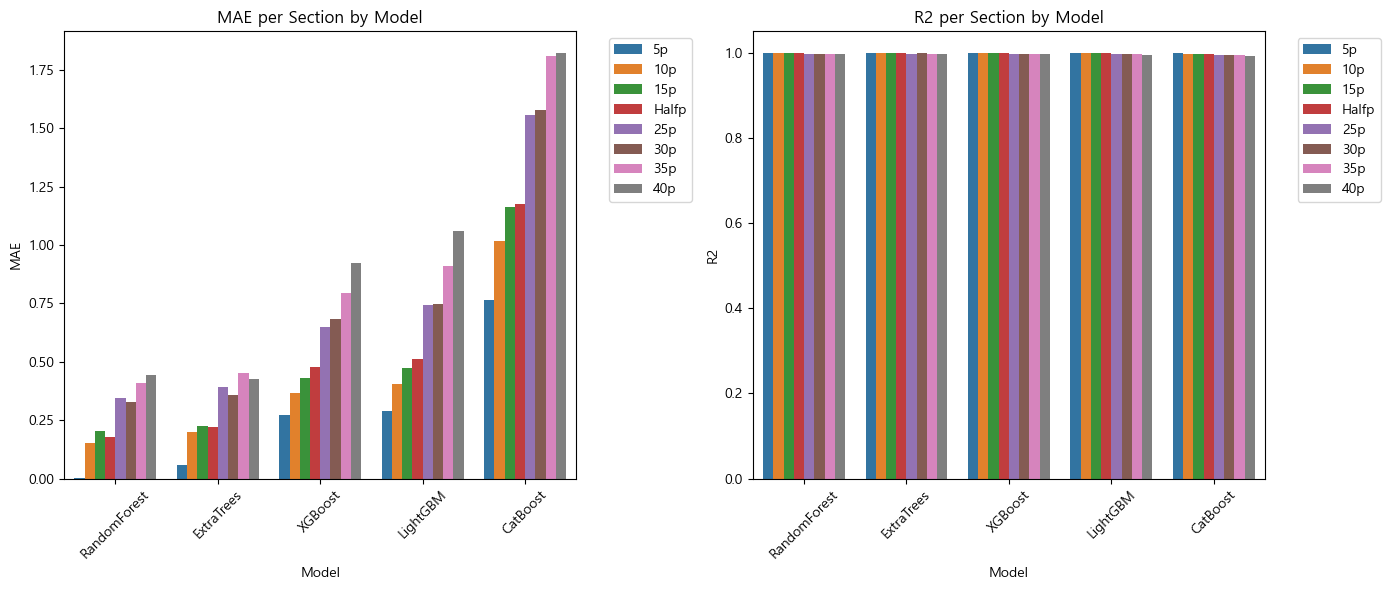

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.base import clone
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1. 데이터 로딩
df = pd.read_csv('./real_final/FINAL_marathons_with_weather.csv')

# 2. 피처 및 타겟 설정
feature_cols = ['Age_group', 'M/F', 'Sub', 'Country', 'temperature_race', 'humidity_race']
target_cols = ['5p', '10p', '15p', 'Halfp', '25p', '30p', '35p', '40p']

# 3. 결측치 제거
df = df.dropna(subset=feature_cols + target_cols).reset_index(drop=True)

# 4. Sub 기준으로 train/test 분리
df_sub3_train, df_sub3_test = train_test_split(df[df['Sub'] == 3], test_size=0.3, random_state=42)
df_sub4_train, df_sub4_test = train_test_split(df[df['Sub'] == 4], test_size=0.3, random_state=42)
df_sub5_train, df_sub5_test = train_test_split(df[df['Sub'] == 5], test_size=0.3, random_state=42)
df_rest = df[~df['Sub'].isin([3, 4, 5])]

df_train = pd.concat([df_rest, df_sub3_train, df_sub4_train, df_sub5_train]).reset_index(drop=True)
df_test = pd.concat([df_sub3_test, df_sub4_test, df_sub5_test]).reset_index(drop=True)

# 5. 원-핫 인코딩
df_full = pd.concat([df_train, df_test], keys=['train', 'test'])
df_full = pd.get_dummies(df_full, columns=['Country'], drop_first=True)

df_train_encoded = df_full.xs('train')
df_test_encoded = df_full.xs('test')

# 6. 데이터 분할
X_train = df_train_encoded.drop(columns=target_cols).select_dtypes(include=[np.number]).values
Y_train = df_train_encoded[target_cols].values
X_test = df_test_encoded.drop(columns=target_cols).select_dtypes(include=[np.number]).values
Y_test = df_test_encoded[target_cols].values

# 7. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. 사용할 모델들 정의
model_dict = {
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, max_depth=20, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_seed=42)
}

results = []

# 9. 모델 학습 및 평가
for model_name, base_model in model_dict.items():
    print(f"\n[{model_name} 학습 진행 중...]")
    models = []
    for i in tqdm(range(Y_train.shape[1]), desc=f"{model_name} Targets"):
        model = clone(base_model)
        model.fit(X_train_scaled, Y_train[:, i])
        models.append(model)

    Y_pred = np.column_stack([model.predict(X_test_scaled) for model in models])

    print(f"\n[테스트셋 성능 평가 결과 - {model_name}]")
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(Y_test[:, i], Y_pred[:, i])
        r2 = r2_score(Y_test[:, i], Y_pred[:, i])
        print(f"{col}: MAE = {mae:.2f} sec/km, R² = {r2:.3f}")
        results.append({'Model': model_name, 'Section': col, 'MAE': mae, 'R2': r2})

# 10. 시각화
results_df = pd.DataFrame(results)

plt.figure(figsize=(14, 6))
for metric in ['MAE', 'R2']:
    plt.subplot(1, 2, 1 if metric == 'MAE' else 2)
    sns.barplot(data=results_df, x='Model', y=metric, hue='Section')
    plt.title(f'{metric} per Section by Model')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()